# Projet Maldive

# 0. Preparatory stage

## Set up the libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

import json
import numpy as np
import random
import math



from pprint import pprint
from collections import Counter
from matplotlib.ticker import MaxNLocator
from itertools import tee



from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from trefle.fitness_functions.output_thresholder import round_to_cls
from trefle.trefle_classifier import TrefleClassifier

from trefle_engine import TrefleFIS



import libraries.measures_calculation
import libraries.trefle_project
import libraries.interpretability_methods
import libraries.interpretability_plots
import libraries.results_plot
from libraries.model_var import ModelVar
from libraries.model_train_cv import *

## Split the dataset
<br>
The first step of the ML process is to split our dataset into training and test parts (subsets). <br> 
<ul>
    <li>You must indicate the path of your original dataset</li>
    <li>You must indicate the path where you want to save the training part</li>
    <li>You must indicate the path where you want to save the test part</li>
</ul>
<br>When a plot is "open" you need to "shut it down" in order to plot the others (button on the upper corner right)

     pH
0     0
1     0
2     0
3     0
4     0
..   ..
99    0
100   0
101   0
102   1
103   1

[104 rows x 1 columns]


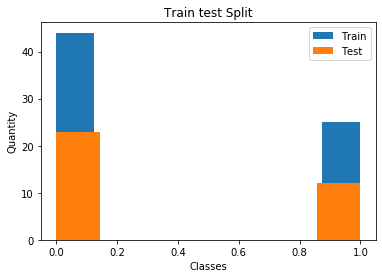

In [43]:
#Read Dataset
#Indicate the path of the original DS HERE:
#--------------------
csv_path_file_name = './datasets/ProtistAmpliconSequenceVariants_ASV_2015.csv'
#--------------------

data_load = pd.read_csv(csv_path_file_name, sep = ';')
target_load = pd.read_csv('./datasets/Env_2015.csv', sep = ';')

#Remove the 0's columns
data_load = data_load.loc[:, (data_load != 0).any(axis=0)]
data_load = data_load.drop(data_load.columns[0], axis=1)
target_load = target_load[['pH']]

# TODO: Changer la colonne à prendre, la lamdba en dessous et lancer ensuite
target_load['pH'] = target_load['pH'].apply(lambda x:1 if x < 6.8 else 0 if x < 7.3 else 1)
#target_load['Herbicide'] = target_load['Herbicide'].apply(lambda x: 1 if x == "yes" else 0)
#target_load['Cu_mg_kg'] = target_load['Cu_mg_kg'].apply(lambda x: 1 if x>100 else 0)

print(target_load)



X = data_load
y = target_load['pH']


#Split it into train test DS
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, stratify=y, random_state=42, test_size=0.33)

plt.hist(y_train, bins='auto', label='Train')

plt.hist(y_test, bins='auto', label='Test')
plt.title("Train test Split")
plt.xlabel('Classes')
plt.ylabel('Quantity')
plt.legend()
plt.show()


#Save separetly in training and test
#It is important to save the training and test sets (we will use the test in the second part)
y_train_modify = np.reshape(y_train, (-1, 1))
train_dataset = np.append(X_train, y_train_modify, axis=1)

y_test_modify = np.reshape(y_test, (-1, 1))
test_dataset = np.append(X_test, y_test_modify, axis=1)

#This indicates to numpy how to format the output (you can create a function for a larger number of variables...)
#format_values = '%1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %1.3f %i'


#Indicate the path where you want to save the training and test part DS HERE:
#--------------------
path_train_csv = './datasets/data_project_train_v2.csv'
path_test_csv = './datasets/data_project_test_v2.csv'
#--------------------
np.savetxt(path_train_csv, train_dataset, delimiter=";")
np.savetxt(path_test_csv, test_dataset, delimiter=";")


<b style="background-color:red;color:white">Question 1</b>:  Comment the plot above (include it into your report)

## Trefle Classifier
<br> In the code below you have a description of the (fuzzy logic-based) classifier that we use along this labo, the theory is provided in the slides of the cours. <br>
Don't forget to change, if necessary, the number of generations (iterations) of your algorithm. 

In [44]:
# Declare the fitness function we want to use
def fit(y_true, y_pred):
    # Here no need to threshold y_pred because we are using a regression
    # metric
    return -mean_squared_error(y_true, y_pred)

#Initialize our classsifier TREFLE
clf = TrefleClassifier(
    n_rules=10,
    n_classes_per_cons=[2],  # In regression, there is no class (i.e. 0)
    n_labels_per_mf=3,  # use 3 labels LOW, MEDIUM, HIGH
    default_cons=[0],  # default rule yield the class 0
    n_max_vars_per_rule=12,  # WBCD dataset has 30 variables, here we force
    # to use a maximum of 3 variables per rule
    # to have a better interpretability
    # In total we can have up to 3*4=12 different variables
    # for a fuzzy system
    
    #Change here the number of generations (if necessary)
    n_generations=100,
    fitness_function=fit,
    verbose=True,
)

## Training and predicting with Trefle
<br> Below you have a simple example of how to:<br>
<ul>
    <li>train a model and make a prediction with it</li>
    <li>save the model in a file</li>
</ul>

In [45]:
#Make a train
y_sklearn = np.reshape(y_train, (-1, 1))

clf.fit(X_train, y_sklearn)
# Make predictions
y_pred = clf.predict_classes(X_test)

clf.print_best_fuzzy_system()

# Evaluate accuracy
score = f1_score(y_test, y_pred)
print("Score on test set: {:.3f}".format(score))

tff = clf.get_best_fuzzy_system_as_tff()

# Export: save the fuzzy model to disk
with open("my_saved_model_trefle.tff", mode="w") as f:
    f.write(tff)

gen	species	std        	min      	avg      	max      	avg_hof  
1  	sp1    	5.55112e-17	-0.362319	-0.362319	-0.362319	-0.361871
1  	sp2    	0.00404639 	-0.376812	-0.361271	-0.347826	-0.357862
2  	sp1    	0.000939313	-0.356168	-0.347952	-0.347796	-0.347825
2  	sp2    	0.0286605  	-0.60099 	-0.361144	-0.344536	-0.347605
3  	sp1    	0.00109482 	-0.347826	-0.344833	-0.339569	-0.344135
3  	sp2    	0.0345169  	-0.608696	-0.360729	-0.338222	-0.342803
4  	sp1    	0.00253878 	-0.347826	-0.340401	-0.333843	-0.337828
4  	sp2    	0.0254612  	-0.550994	-0.355337	-0.333333	-0.334625
5  	sp1    	0.00142455 	-0.340267	-0.333793	-0.333333	-0.333333
5  	sp2    	0.0379474  	-0.54413 	-0.358419	-0.333333	-0.333333
6  	sp1    	0.00208133 	-0.347826	-0.3339  	-0.333333	-0.333333
6  	sp2    	0.0258042  	-0.533477	-0.351653	-0.291486	-0.33159 
7  	sp1    	0.0120438  	-0.341717	-0.308912	-0.291486	-0.300681
7  	sp2    	0.0313477  	-0.446625	-0.341311	-0.289982	-0.29221 
8  	sp1    	0.0119672  	-0.32575 	-0.295

65 	sp1    	0.0133225  	-0.309923	-0.253304	-0.244304	-0.245284
65 	sp2    	0.0666442  	-0.636889	-0.336662	-0.244304	-0.24519 
66 	sp1    	0.00955346 	-0.300841	-0.248271	-0.242993	-0.244249
66 	sp2    	0.0725789  	-0.610528	-0.329682	-0.240679	-0.243989
67 	sp1    	0.00904089 	-0.281306	-0.244989	-0.231083	-0.239299
67 	sp2    	0.0783868  	-0.623188	-0.327465	-0.231083	-0.2389  
68 	sp1    	0.0100111  	-0.272142	-0.238944	-0.228501	-0.23071 
68 	sp2    	0.0932105  	-0.651231	-0.349486	-0.228501	-0.230602
69 	sp1    	0.0133608  	-0.284013	-0.238106	-0.228501	-0.228501
69 	sp2    	0.0758488  	-0.617364	-0.331103	-0.228501	-0.228501
70 	sp1    	0.0121364  	-0.2809  	-0.235731	-0.228501	-0.228501
70 	sp2    	0.0913668  	-0.637794	-0.340329	-0.228501	-0.228501
71 	sp1    	0.0142897  	-0.288324	-0.237197	-0.228501	-0.228501
71 	sp2    	0.0819903  	-0.637681	-0.328567	-0.228501	-0.228501
72 	sp1    	0.0104391  	-0.276753	-0.23551 	-0.228501	-0.228501
72 	sp2    	0.0892721  	-0.635736	-0.336

## 1.2 Model-parameter search

In [46]:
score = f1_score(y_test, y_pred)
print("Score on test set: {:.3f}".format(score))

Score on test set: 0.235


Now that the fitness function have been defined, we may search values for other parameters of the algorithm. In this part we will focus on the size (complexity) of the model, represented by the number of rules and the number of variables per rule.

<b style="background-color:red;color:white">Question 5</b>: Explain what are the implications of these two parameters (i.e., number of rules and number of variables per rule) on the models, in terms of both performance and interpretability.
<br>
<b style="background-color:red;color:white">Question 6</b>: If you have setted your algorithm up to use 6 rules and 5 variables per rule on a dataset composeed of 100 features, how many features could be used at most by a model?
<br>

** Important:** Before continuing, don't forget to set the right weights for sensitivity, specificity, and RMSE!

### Coarse estimation of the model size
Not knowing the complexity of the required models, we must first roughly estimate them. This is done by exploring a relatively large range of model sizes. Performing a grid search (i.e., exploring both parameters simultaneously) would be the best approach, but that may be extremely costly and time consuming. Instead, we will explore one of the parameters, the number of rules. 

** Note:** Before performing the experiments, don't forget to set the values for the <b>rules_number_vec</b>. They represent the number of rules, pay attention to the size of the model. Don't change the value of 'var_per_rule_fix'.

<b style="background-color:red;color:white">Question 7</b>: In your opinion, why did we decide to first explore the number of rules instead of the number of variables per rule?
<br>
<b style="background-color:red;color:white">Question 8</b>: Which values have you decided to test at this stage? Why this range?
<br>


In [47]:
%load_ext autoreload
%autoreload

##############fitness function
def fit (y_true, y_pred):
    
    y_pred_bin = round_to_cls(y_pred, n_classes=2)
    tn, fp, fn, tp = libraries.trefle_project.getConfusionMatrixValues(y_true, y_pred_bin)

    return libraries.measures_calculation.calculateF1(tn, fp, fn, tp)

clf.fitness_function=fit
###############

#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules'


#Perform Cross-validation
#Change here the number of folds (if necessary)
k_fold_number = 5
cv_kf = KFold(n_splits=k_fold_number, random_state=42, shuffle=True)
array_index_train_test = cv_kf.split(X_train)
array_index_train_test, array_index_train_test_copy = tee(array_index_train_test)

model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)


#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience ('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [3,5, 7,10]
var_per_rule_fix = 4
#--------------------

for qty_of_rule in rules_number_vec:
    model_train_obj.number_rule = qty_of_rule
    model_train_obj.var_per_rule = var_per_rule_fix
    model_train_obj.execute_cv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.122492
1  	sp2    	0.232839	0  	0.287136	0.535211	0.519138
2  	sp1    	0       	0.535211	0.535211	0.535211	0.525787
2  	sp2    	0.202147	0       	0.403435	0.550725	0.530011
3  	sp1    	0.0109624	0.520548	0.533183	0.550725	0.547774
3  	sp2    	0.224873 	0       	0.36627 	0.550725	0.548102
4  	sp1    	0.0107913	0.520548	0.538466	0.550725	0.550725
4  	sp2    	0.21182  	0       	0.407296	0.553846	0.550855
5  	sp1    	0.00512593	0.527778	0.547599	0.558824	0.551322
5  	sp2    	0.20957   	0       	0.415864	0.558824	0.55166 
6  	sp1    	0.00509099	0.527778	0.547943	0.558824	0.552725
6  	sp2    	0.208302  	0       	0.409293	0.558824	0.553737
7  	sp1    	0.0102483 	0.53125 	0.554477	0.567164	0.566469
7  	sp2    	0.200632  	0       	0.42309 	0.567164	0.566817
8  	sp1    	0.0177507 	0.527778	0.548127	0.567164	0.567164
8  	sp2    	0.217131  	0   

70 	sp1    	0.0390588 	0.538462	0.632693	0.680851	0.679078
70 	sp2    	0.215175  	0       	0.462342	0.680851	0.679078
71 	sp1    	0.0397708 	0.530612	0.633553	0.680851	0.680851
71 	sp2    	0.227709  	0       	0.440281	0.680851	0.680851
72 	sp1    	0.0380785 	0.530612	0.636279	0.680851	0.680851
72 	sp2    	0.217425  	0       	0.449787	0.680851	0.680851
73 	sp1    	0.0393959 	0.530612	0.635162	0.680851	0.680851
73 	sp2    	0.207631  	0       	0.466349	0.680851	0.680851
74 	sp1    	0.0405602 	0.52    	0.628224	0.680851	0.680851
74 	sp2    	0.206663  	0       	0.469282	0.680851	0.680851
75 	sp1    	0.040518  	0.528302	0.627927	0.680851	0.680851
75 	sp2    	0.138329  	0       	0.523192	0.680851	0.680851
76 	sp1    	0.0407676 	0.530612	0.626056	0.680851	0.680851
76 	sp2    	0.220987  	0       	0.448387	0.680851	0.680851
77 	sp1    	0.0428098 	0.521739	0.62833 	0.680851	0.680851
77 	sp2    	0.213782  	0       	0.45343 	0.680851	0.680851
78 	sp1    	0.0443428 	0.509804	0.633364	0.680851	0.6808

39 	sp2    	0.268925  	0       	0.442364	0.688525	0.685157
40 	sp1    	0.0246047 	0.611111	0.650425	0.688525	0.688525
40 	sp2    	0.243677  	0       	0.482823	0.688525	0.688525
41 	sp1    	0.0283102 	0.591549	0.638469	0.688525	0.688525
41 	sp2    	0.246292  	0       	0.470259	0.688525	0.688525
42 	sp1    	0.026591  	0.611111	0.649292	0.688525	0.688525
42 	sp2    	0.246484  	0       	0.465094	0.688525	0.688525
43 	sp1    	0.0239492 	0.611111	0.648216	0.688525	0.688525
43 	sp2    	0.230818  	0       	0.486109	0.688525	0.688525
44 	sp1    	0.0198512 	0.611111	0.639429	0.688525	0.688525
44 	sp2    	0.232523  	0       	0.48458 	0.688525	0.688525
45 	sp1    	0.0312781 	0.56    	0.630703	0.688525	0.688525
45 	sp2    	0.199732  	0       	0.511873	0.688525	0.688525
46 	sp1    	0.0258625 	0.611111	0.646723	0.688525	0.688525
46 	sp2    	0.244648  	0       	0.472171	0.688525	0.688525
47 	sp1    	0.0287462 	0.60274 	0.645361	0.688525	0.688525
47 	sp2    	0.25173   	0       	0.448457	0.688525	0.6885

9  	sp1    	0.00786605	0.542857	0.568866	0.575758	0.575758 
9  	sp2    	0.198857  	0       	0.425851	0.575758	0.575758 
10 	sp1    	0.00749951	0.550725	0.569922	0.575758	0.575758 
10 	sp2    	0.176752  	0       	0.454137	0.575758	0.575758 
11 	sp1    	0.00669251	0.550725	0.571508	0.575758	0.575758 
11 	sp2    	0.197708  	0       	0.431269	0.59375 	0.576507 
12 	sp1    	0.00777141	0.567164	0.582815	0.59375 	0.590705 
12 	sp2    	0.228256  	0       	0.388613	0.59375 	0.590705 
13 	sp1    	0.0077169 	0.567164	0.583708	0.59375 	0.59375  
13 	sp2    	0.224716  	0       	0.397156	0.603175	0.594143 
14 	sp1    	0.00975009	0.558824	0.588284	0.603175	0.599248 
14 	sp2    	0.20498   	0       	0.40606 	0.603175	0.59964  
15 	sp1    	0.00848752	0.575758	0.593062	0.603175	0.603175 
15 	sp2    	0.217267  	0       	0.399284	0.603175	0.603175 
16 	sp1    	0.00977035	0.567164	0.59264 	0.603175	0.603175 
16 	sp2    	0.222278  	0       	0.396846	0.603175	0.603175 
17 	sp1    	0.010829  	0.575758	0.592676

77 	sp2    	0.230559  	0       	0.421967	0.655172	0.655172 
78 	sp1    	0.0177251 	0.603175	0.631986	0.655172	0.655172 
78 	sp2    	0.22606   	0       	0.434208	0.666667	0.655651 
79 	sp1    	0.0253517 	0.603175	0.641267	0.678571	0.671131 
79 	sp2    	0.235188  	0       	0.415462	0.678571	0.671131 
80 	sp1    	0.0254104 	0.59375 	0.64289 	0.678571	0.675099 
80 	sp2    	0.228308  	0       	0.430264	0.678571	0.675099 
81 	sp1    	0.0277653 	0.59375 	0.640791	0.678571	0.678571 
81 	sp2    	0.246092  	0       	0.429383	0.678571	0.678571 
82 	sp1    	0.0264913 	0.604651	0.647865	0.678571	0.678571 
82 	sp2    	0.223945  	0       	0.459566	0.678571	0.678571 
83 	sp1    	0.0290368 	0.59375 	0.636623	0.678571	0.678571 
83 	sp2    	0.229926  	0       	0.427459	0.678571	0.678571 
84 	sp1    	0.0293656 	0.59375 	0.641072	0.678571	0.678571 
84 	sp2    	0.229192  	0       	0.410927	0.678571	0.678571 
85 	sp1    	0.0282919 	0.603175	0.64245 	0.678571	0.678571 
85 	sp2    	0.226097  	0       	0.417514

45 	sp2    	0.230376   	0       	0.458808	0.723404	0.723404
46 	sp1    	0.020209   	0.64    	0.700625	0.723404	0.723404
46 	sp2    	0.211755   	0       	0.497608	0.723404	0.723404
47 	sp1    	0.0189787  	0.666667	0.700495	0.723404	0.723404
47 	sp2    	0.247686   	0       	0.448851	0.723404	0.723404
48 	sp1    	0.0203633  	0.653846	0.696477	0.723404	0.723404
48 	sp2    	0.262909   	0       	0.437426	0.723404	0.723404
49 	sp1    	0.0200577  	0.666667	0.69855 	0.723404	0.723404
49 	sp2    	0.234091   	0       	0.46013 	0.723404	0.723404
50 	sp1    	0.0178923  	0.654545	0.698269	0.723404	0.723404
50 	sp2    	0.242187   	0       	0.460245	0.723404	0.723404
51 	sp1    	0.0196454  	0.653846	0.69925 	0.723404	0.723404
51 	sp2    	0.250203   	0       	0.455265	0.723404	0.723404
52 	sp1    	0.0196397  	0.654545	0.695259	0.723404	0.723404
52 	sp2    	0.238352   	0       	0.483203	0.723404	0.723404
53 	sp1    	0.0222052  	0.627451	0.689907	0.723404	0.723404
53 	sp2    	0.27303    	0       	0.41869

13 	sp2    	0.222152  	0       	0.414806	0.606061	0.59155 
14 	sp1    	0.0225762 	0.53125 	0.571198	0.606061	0.594133
14 	sp2    	0.216267  	0       	0.427551	0.606061	0.594133
15 	sp1    	0.0207049 	0.540541	0.572651	0.606061	0.596716
15 	sp2    	0.196182  	0       	0.454525	0.606061	0.596716
16 	sp1    	0.0197248 	0.53125 	0.576751	0.606061	0.600784
16 	sp2    	0.163228  	0       	0.489862	0.606061	0.601161
17 	sp1    	0.0188175 	0.53125 	0.578571	0.606061	0.606061
17 	sp2    	0.215837  	0       	0.429264	0.606061	0.606061
18 	sp1    	0.0220903 	0.53125 	0.576846	0.606061	0.606061
18 	sp2    	0.227927  	0       	0.402597	0.606061	0.606061
19 	sp1    	0.0156474 	0.53125 	0.58258 	0.606061	0.606061
19 	sp2    	0.228099  	0       	0.411078	0.606061	0.606061
20 	sp1    	0.0218673 	0.53125 	0.580094	0.606061	0.606061
20 	sp2    	0.225968  	0       	0.405794	0.606061	0.606061
21 	sp1    	0.0223105 	0.53125 	0.577725	0.606061	0.606061
21 	sp2    	0.209648  	0       	0.430791	0.606061	0.6060

83 	sp1    	0.0367483 	0.540541	0.679928	0.714286	0.714286
83 	sp2    	0.260976  	0       	0.381118	0.714286	0.714286
84 	sp1    	0.0348024 	0.594595	0.67584 	0.714286	0.714286
84 	sp2    	0.223324  	0       	0.462933	0.714286	0.714286
85 	sp1    	0.0435724 	0.550725	0.665817	0.714286	0.714286
85 	sp2    	0.252311  	0       	0.39596 	0.714286	0.714286
86 	sp1    	0.054688  	0.333333	0.664934	0.714286	0.714286
86 	sp2    	0.250833  	0       	0.413493	0.714286	0.714286
87 	sp1    	0.0407667 	0.565217	0.672614	0.714286	0.714286
87 	sp2    	0.253562  	0       	0.419889	0.714286	0.714286
88 	sp1    	0.0555248 	0.4     	0.660659	0.714286	0.714286
88 	sp2    	0.214824  	0       	0.462564	0.714286	0.714286
89 	sp1    	0.0497311 	0.548387	0.657329	0.714286	0.714286
89 	sp2    	0.219697  	0       	0.459303	0.714286	0.714286
90 	sp1    	0.0510582 	0.482759	0.663747	0.714286	0.714286
90 	sp2    	0.211509  	0       	0.45558 	0.714286	0.714286
91 	sp1    	0.0445133 	0.540541	0.676929	0.714286	0.7142

53 	sp1    	0.0449484	0.347826	0.677228	0.727273	0.723096
53 	sp2    	0.231892 	0       	0.399156	0.727273	0.723096
54 	sp1    	0.0509653	0.347826	0.68315 	0.727273	0.723485
54 	sp2    	0.241649 	0       	0.377971	0.727273	0.723485
55 	sp1    	0.0461819	0.493151	0.687891	0.727273	0.724537
55 	sp2    	0.204764 	0       	0.443828	0.727273	0.724537
56 	sp1    	0.102912 	0.272727	0.663729	0.727273	0.72601 
56 	sp2    	0.237915 	0       	0.376467	0.727273	0.72601 
57 	sp1    	0.0517916	0.485714	0.686308	0.727273	0.727273
57 	sp2    	0.234912 	0       	0.43228 	0.727273	0.727273
58 	sp1    	0.0803881	0.347826	0.669306	0.727273	0.727273
58 	sp2    	0.176906 	0       	0.480277	0.727273	0.727273
59 	sp1    	0.0929446	0.272727	0.658654	0.727273	0.727273
59 	sp2    	0.226706 	0       	0.439128	0.727273	0.727273
60 	sp1    	0.0705964	0.513514	0.667464	0.727273	0.727273
60 	sp2    	0.249085 	0       	0.397231	0.727273	0.727273
61 	sp1    	0.0696487	0.513514	0.668828	0.727273	0.727273
61 	sp2    	0.

23 	sp2    	0.222123 	0       	0.488219	0.698413	0.693666
24 	sp1    	0.0289691	0.590164	0.657649	0.698413	0.698413
24 	sp2    	0.25448  	0       	0.425293	0.698413	0.698413
25 	sp1    	0.0243502	0.612903	0.664732	0.698413	0.698413
25 	sp2    	0.219724 	0       	0.480943	0.698413	0.698413
26 	sp1    	0.0325801	0.590164	0.658491	0.698413	0.698413
26 	sp2    	0.238424 	0       	0.446141	0.698413	0.698413
27 	sp1    	0.0319765	0.590164	0.66265 	0.7     	0.698479
27 	sp2    	0.232606 	0       	0.471276	0.7     	0.698479
28 	sp1    	0.02992  	0.612903	0.66436 	0.7     	0.698545
28 	sp2    	0.244165 	0       	0.443062	0.7     	0.698545
29 	sp1    	0.0295218	0.612903	0.660055	0.7     	0.698611
29 	sp2    	0.250195 	0       	0.431339	0.7     	0.698611
30 	sp1    	0.0288216	0.612903	0.662303	0.7     	0.69881 
30 	sp2    	0.267138 	0       	0.41546 	0.7     	0.69881 
31 	sp1    	0.0287958	0.612903	0.663737	0.7     	0.69914 
31 	sp2    	0.243333 	0       	0.458307	0.7     	0.69914 
32 	sp1    	0.

94 	sp2    	0.247847 	0       	0.491407	0.736842	0.736842
95 	sp1    	0.0275831	0.633333	0.692744	0.736842	0.736842
95 	sp2    	0.227811 	0       	0.516823	0.736842	0.736842
96 	sp1    	0.0310726	0.633333	0.696111	0.736842	0.736842
96 	sp2    	0.17852  	0       	0.547167	0.736842	0.736842
97 	sp1    	0.0292883	0.633333	0.697097	0.736842	0.736842
97 	sp2    	0.242634 	0       	0.48266 	0.736842	0.736842
98 	sp1    	0.0276183	0.647059	0.699981	0.736842	0.736842
98 	sp2    	0.228814 	0       	0.492074	0.736842	0.736842
99 	sp1    	0.0290977	0.633333	0.698158	0.736842	0.736842
99 	sp2    	0.235989 	0       	0.484127	0.736842	0.736842
100	sp1    	0.0295157	0.622951	0.693674	0.736842	0.736842
100	sp2    	0.192572 	0       	0.542286	0.736842	0.736842
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.187172
1  	sp2    	0.207753	0  	0.197502	0.542857	0.500891
2  	sp1    	0.00252864	0.535211	0.541901	0.542857	0.519073
2  	sp2    	0.221381  	0       	0.358585	0.557377	0.

64 	sp1    	0.0381818 	0.584615	0.678783	0.723404	0.723404
64 	sp2    	0.219995  	0       	0.48889 	0.723404	0.723404
65 	sp1    	0.038856  	0.567164	0.686706	0.723404	0.723404
65 	sp2    	0.265507  	0       	0.427167	0.75    	0.724512
66 	sp1    	0.034576  	0.584615	0.714986	0.75    	0.75    
66 	sp2    	0.216994  	0       	0.476763	0.75    	0.75    
67 	sp1    	0.0434991 	0.584615	0.710377	0.765957	0.750665
67 	sp2    	0.21146   	0       	0.49578 	0.765957	0.75133 
68 	sp1    	0.0427999 	0.577778	0.710407	0.765957	0.751995
68 	sp2    	0.239007  	0       	0.454063	0.765957	0.753324
69 	sp1    	0.0385701 	0.603175	0.715128	0.765957	0.754654
69 	sp2    	0.255946  	0       	0.43122 	0.765957	0.755984
70 	sp1    	0.0368065 	0.612903	0.721131	0.765957	0.757979
70 	sp2    	0.247385  	0       	0.441042	0.765957	0.758644
71 	sp1    	0.0443457 	0.567164	0.715232	0.765957	0.761303
71 	sp2    	0.23603   	0       	0.464819	0.765957	0.761968
72 	sp1    	0.0432477 	0.59375 	0.718311	0.765957	0.7659

32 	sp2    	0.254791   	0       	0.417008	0.711111	0.697469
33 	sp1    	0.0399026  	0.57971 	0.671574	0.711111	0.710532
33 	sp2    	0.246605   	0       	0.450311	0.711111	0.710648
34 	sp1    	0.0393888  	0.571429	0.673489	0.714286	0.711376
34 	sp2    	0.20723    	0       	0.514144	0.714286	0.711508
35 	sp1    	0.0355216  	0.597015	0.674888	0.723404	0.713954
35 	sp2    	0.244426   	0       	0.452398	0.723404	0.713954
36 	sp1    	0.0375696  	0.588235	0.678184	0.723404	0.715755
36 	sp2    	0.239024   	0       	0.465663	0.723404	0.715887
37 	sp1    	0.0333864  	0.603774	0.680964	0.723404	0.7182  
37 	sp2    	0.243108   	0       	0.456676	0.723404	0.718713
38 	sp1    	0.0391322  	0.575758	0.675771	0.723404	0.723404
38 	sp2    	0.251569   	0       	0.436687	0.723404	0.723404
39 	sp1    	0.0363318  	0.603175	0.68189 	0.723404	0.723404
39 	sp2    	0.252396   	0       	0.437028	0.723404	0.723404
40 	sp1    	0.0407274  	0.584615	0.677645	0.723404	0.723404
40 	sp2    	0.252766   	0       	0.43709

gen	species	std	min     	avg     	max     	avg_hof 
1  	sp1    	0  	0.533333	0.533333	0.533333	0.535769
1  	sp2    	0.236416	0       	0.336382	0.571429	0.547238
2  	sp1    	0.00563789	0.547945	0.561066	0.571429	0.567069
2  	sp2    	0.225653  	0       	0.382967	0.571429	0.567069
3  	sp1    	0.00624496	0.547945	0.559412	0.571429	0.568746
3  	sp2    	0.215209  	0       	0.402524	0.571429	0.568746
4  	sp1    	0.00568204	0.555556	0.563537	0.571429	0.571429
4  	sp2    	0.225272  	0       	0.3944  	0.571429	0.571429
5  	sp1    	0.00827165	0.547945	0.561463	0.571429	0.571429
5  	sp2    	0.229119  	0       	0.384421	0.571429	0.571429
6  	sp1    	0.010821  	0.550725	0.571424	0.603175	0.583513
6  	sp2    	0.224696  	0       	0.393864	0.603175	0.583858
7  	sp1    	0.0148688 	0.555556	0.572258	0.612903	0.591295
7  	sp2    	0.195668  	0       	0.43641 	0.612903	0.592006
8  	sp1    	0.0255114 	0.533333	0.570284	0.612903	0.601698
8  	sp2    	0.214071  	0       	0.411048	0.612903	0.602726
9  	sp1    	0

70 	sp2    	0.229857  	0       	0.453093	0.716981	0.716981
71 	sp1    	0.0386108 	0.575758	0.653756	0.716981	0.716981
71 	sp2    	0.243252  	0       	0.455954	0.716981	0.716981
72 	sp1    	0.0383515 	0.575758	0.658881	0.716981	0.716981
72 	sp2    	0.203528  	0       	0.50416 	0.727273	0.71741 
73 	sp1    	0.0387818 	0.575758	0.670548	0.727273	0.719983
73 	sp2    	0.240041  	0       	0.454481	0.727273	0.719983
74 	sp1    	0.0408155 	0.567164	0.677462	0.727273	0.722556
74 	sp2    	0.22976   	0       	0.469056	0.727273	0.722985
75 	sp1    	0.0408445 	0.575758	0.670226	0.727273	0.727273
75 	sp2    	0.210713  	0       	0.492135	0.727273	0.727273
76 	sp1    	0.0425016 	0.588235	0.673655	0.727273	0.727273
76 	sp2    	0.212768  	0       	0.475636	0.727273	0.727273
77 	sp1    	0.0411085 	0.575758	0.676587	0.727273	0.727273
77 	sp2    	0.216407  	0       	0.465707	0.727273	0.727273
78 	sp1    	0.0414367 	0.575758	0.675438	0.727273	0.727273
78 	sp2    	0.2132    	0       	0.457653	0.727273	0.7272

40 	sp1    	0.135678  	0.0833333	0.596471	0.681818	0.667298
40 	sp2    	0.25574   	0        	0.36094 	0.681818	0.668561
41 	sp1    	0.0447487 	0.5      	0.632734	0.681818	0.668561
41 	sp2    	0.231293  	0        	0.405708	0.681818	0.669192
42 	sp1    	0.0355773 	0.514286 	0.635719	0.681818	0.669823
42 	sp2    	0.23559   	0        	0.401615	0.681818	0.672348
43 	sp1    	0.0362821 	0.507042 	0.632212	0.681818	0.67298 
43 	sp2    	0.236267  	0        	0.395232	0.681818	0.673611
44 	sp1    	0.0410816 	0.514286 	0.629599	0.681818	0.676136
44 	sp2    	0.223361  	0        	0.421757	0.681818	0.679293
45 	sp1    	0.0385778 	0.507042 	0.629364	0.681818	0.681818
45 	sp2    	0.252805  	0        	0.390435	0.697674	0.682479
46 	sp1    	0.0400198 	0.535211 	0.641446	0.697674	0.687104
46 	sp2    	0.251477  	0        	0.42054 	0.697674	0.687104
47 	sp1    	0.0445664 	0.535211 	0.635202	0.697674	0.689086
47 	sp2    	0.226837  	0        	0.433437	0.697674	0.689086
48 	sp1    	0.0446788 	0.535211 	0.65010

8  	sp1    	0.0257283  	0.56    	0.619285	0.647059	0.640807
8  	sp2    	0.224562   	0       	0.46411 	0.65625 	0.642753
9  	sp1    	0.0215169  	0.576923	0.630661	0.666667	0.655025
9  	sp2    	0.211302   	0       	0.470962	0.666667	0.655025
10 	sp1    	0.0231406  	0.578947	0.630047	0.666667	0.660641
10 	sp2    	0.217283   	0       	0.48472 	0.666667	0.661458
11 	sp1    	0.0256331  	0.586667	0.627618	0.666667	0.666667
11 	sp2    	0.22945    	0       	0.459261	0.666667	0.666667
12 	sp1    	0.0324076  	0.555556	0.62682 	0.666667	0.666667
12 	sp2    	0.222625   	0       	0.481442	0.666667	0.666667
13 	sp1    	0.0327905  	0.575758	0.630388	0.666667	0.666667
13 	sp2    	0.223789   	0       	0.477542	0.7     	0.668056
14 	sp1    	0.0382278  	0.576923	0.662112	0.7     	0.7     
14 	sp2    	0.229813   	0       	0.476676	0.7     	0.7     
15 	sp1    	0.0338482  	0.6     	0.660601	0.7     	0.7     
15 	sp2    	0.240399   	0       	0.469223	0.7     	0.7     
16 	sp1    	0.0354529  	0.576923	0.65630

76 	sp2    	0.202846   	0       	0.507579	0.711864	0.701382
77 	sp1    	0.023614   	0.6     	0.68129 	0.711864	0.701382
77 	sp2    	0.197404   	0       	0.52452 	0.711864	0.701877
78 	sp1    	0.0324112  	0.588235	0.670634	0.711864	0.702371
78 	sp2    	0.219559   	0       	0.497113	0.711864	0.702865
79 	sp1    	0.0349878  	0.575342	0.662452	0.711864	0.703854
79 	sp2    	0.203038   	0       	0.508671	0.711864	0.704348
80 	sp1    	0.0351681  	0.588235	0.665289	0.711864	0.705831
80 	sp2    	0.242228   	0       	0.457722	0.711864	0.706326
81 	sp1    	0.039788   	0.576923	0.661067	0.711864	0.70682 
81 	sp2    	0.21507    	0       	0.492626	0.711864	0.707315
82 	sp1    	0.0385408  	0.576923	0.667583	0.711864	0.708303
82 	sp2    	0.242497   	0       	0.455556	0.711864	0.709292
83 	sp1    	0.0365483  	0.588235	0.672047	0.711864	0.712258
83 	sp2    	0.242402   	0       	0.465868	0.711864	0.712258
84 	sp1    	0.0414365  	0.588235	0.666449	0.711864	0.712258
84 	sp2    	0.215086   	0       	0.51514

45 	sp1    	0.0230861 	0.567164	0.645751	0.666667	0.666667
45 	sp2    	0.247409  	0       	0.389789	0.666667	0.666667
46 	sp1    	0.0232004 	0.567164	0.643714	0.666667	0.666667
46 	sp2    	0.226654  	0       	0.428995	0.666667	0.666667
47 	sp1    	0.0214653 	0.567164	0.645631	0.666667	0.666667
47 	sp2    	0.217948  	0       	0.442618	0.678571	0.667163
48 	sp1    	0.0227422 	0.59375 	0.650251	0.678571	0.673115
48 	sp2    	0.242851  	0       	0.428599	0.678571	0.673115
49 	sp1    	0.0240376 	0.584615	0.648411	0.678571	0.675595
49 	sp2    	0.244854  	0       	0.442639	0.678571	0.675595
50 	sp1    	0.0270988 	0.584615	0.650735	0.678571	0.678571
50 	sp2    	0.236862  	0       	0.4389  	0.678571	0.678571
51 	sp1    	0.0281117 	0.575758	0.647784	0.678571	0.678571
51 	sp2    	0.21722   	0       	0.452445	0.678571	0.678571
52 	sp1    	0.0274849 	0.584615	0.649244	0.678571	0.678571
52 	sp2    	0.243176  	0       	0.42499 	0.678571	0.678571
53 	sp1    	0.0282787 	0.584615	0.646699	0.678571	0.6785

13 	sp2    	0.246034  	0        	0.412067 	0.695652 	0.681468
14 	sp1    	0.0364594 	0.571429 	0.652774 	0.695652 	0.68988 
14 	sp2    	0.247002  	0        	0.420893 	0.695652 	0.68988 
15 	sp1    	0.0347122 	0.588235 	0.652768 	0.695652 	0.69358 
15 	sp2    	0.229533  	0        	0.46503  	0.695652 	0.694123
16 	sp1    	0.0369233 	0.571429 	0.656266 	0.695652 	0.695652
16 	sp2    	0.210522  	0        	0.495083 	0.695652 	0.695652
17 	sp1    	0.0383626 	0.588235 	0.656576 	0.708333 	0.697561
17 	sp2    	0.264084  	0        	0.448605 	0.708333 	0.69809 
18 	sp1    	0.0337478 	0.597015 	0.654781 	0.708333 	0.700425
18 	sp2    	0.23105   	0        	0.490193 	0.723404 	0.703167
19 	sp1    	0.0379316 	0.588235 	0.66174  	0.723404 	0.714123
19 	sp2    	0.227753  	0        	0.48698  	0.723404 	0.714532
20 	sp1    	0.040318  	0.597015 	0.670142 	0.723404 	0.721986
20 	sp2    	0.257762  	0        	0.449842 	0.723404 	0.721986
21 	sp1    	0.04055   	0.57971  	0.672885 	0.723404 	0.723404
21 	sp2 

80 	sp1    	0.0428755 	0.59375  	0.690383 	0.73913  	0.73913 
80 	sp2    	0.241464  	0        	0.473431 	0.73913  	0.73913 
81 	sp1    	0.0409589 	0.612903 	0.691838 	0.73913  	0.73913 
81 	sp2    	0.228485  	0        	0.453977 	0.73913  	0.73913 
82 	sp1    	0.0418622 	0.606061 	0.689763 	0.73913  	0.73913 
82 	sp2    	0.229029  	0        	0.45601  	0.73913  	0.73913 
83 	sp1    	0.0384681 	0.597015 	0.694695 	0.73913  	0.73913 
83 	sp2    	0.232643  	0        	0.463862 	0.73913  	0.73913 
84 	sp1    	0.0384342 	0.588235 	0.694464 	0.73913  	0.73913 
84 	sp2    	0.244678  	0        	0.457159 	0.73913  	0.73913 
85 	sp1    	0.0374567 	0.597015 	0.693306 	0.73913  	0.73913 
85 	sp2    	0.2658    	0        	0.416092 	0.755556 	0.739815
86 	sp1    	0.0388199 	0.597015 	0.697316 	0.755556 	0.740499
86 	sp2    	0.264814  	0        	0.432042 	0.755556 	0.740499
87 	sp1    	0.0405305 	0.597015 	0.694684 	0.755556 	0.742552
87 	sp2    	0.261465  	0        	0.441194 	0.755556 	0.742552
88 	sp1 

48 	sp1    	0.0304564 	0.57971 	0.638832	0.678571	0.678571
48 	sp2    	0.229637  	0       	0.444616	0.678571	0.678571
49 	sp1    	0.0312453 	0.557377	0.627566	0.678571	0.678571
49 	sp2    	0.200324  	0       	0.474766	0.678571	0.678571
50 	sp1    	0.0321338 	0.565217	0.633971	0.678571	0.678571
50 	sp2    	0.205996  	0       	0.47674 	0.678571	0.678571
51 	sp1    	0.0323058 	0.567164	0.634267	0.678571	0.678571
51 	sp2    	0.212625  	0       	0.450636	0.678571	0.678571
52 	sp1    	0.0334034 	0.567164	0.635657	0.678571	0.678571
52 	sp2    	0.212902  	0       	0.451981	0.678571	0.678571
53 	sp1    	0.0345689 	0.575758	0.635081	0.678571	0.678571
53 	sp2    	0.196481  	0       	0.460853	0.678571	0.678571
54 	sp1    	0.0335856 	0.57971 	0.629599	0.678571	0.678571
54 	sp2    	0.236233  	0       	0.423657	0.678571	0.678571
55 	sp1    	0.0337439 	0.576271	0.629323	0.678571	0.678571
55 	sp2    	0.243608  	0       	0.411074	0.678571	0.678571
56 	sp1    	0.0343058 	0.576271	0.624811	0.678571	0.6785

17 	sp1    	0.0347859 	0.513514	0.575717	0.633333	0.626429
17 	sp2    	0.22794   	0       	0.406593	0.666667	0.629398
18 	sp1    	0.042906  	0.520548	0.589911	0.666667	0.649513
18 	sp2    	0.173662  	0       	0.462744	0.666667	0.649513
19 	sp1    	0.0413363 	0.516129	0.597925	0.666667	0.654933
19 	sp2    	0.18633   	0       	0.449434	0.666667	0.654933
20 	sp1    	0.0451216 	0.493151	0.593237	0.666667	0.660291
20 	sp2    	0.203853  	0       	0.422417	0.666667	0.660291
21 	sp1    	0.047206  	0.483871	0.597248	0.666667	0.664855
21 	sp2    	0.215488  	0       	0.408088	0.666667	0.664855
22 	sp1    	0.0369772 	0.545455	0.610411	0.666667	0.666667
22 	sp2    	0.242805  	0       	0.376576	0.666667	0.666667
23 	sp1    	0.0470159 	0.483871	0.608439	0.666667	0.666667
23 	sp2    	0.225606  	0       	0.404478	0.666667	0.666667
24 	sp1    	0.0397703 	0.513514	0.626998	0.666667	0.666667
24 	sp2    	0.240942  	0       	0.375251	0.678571	0.667163
25 	sp1    	0.0384761 	0.5     	0.626873	0.680851	0.6702

86 	sp2    	0.228023  	0       	0.44409 	0.765957	0.765957
87 	sp1    	0.0444316 	0.603175	0.699811	0.765957	0.765957
87 	sp2    	0.258788  	0       	0.419047	0.765957	0.765957
88 	sp1    	0.0488551 	0.6     	0.693803	0.765957	0.765957
88 	sp2    	0.210112  	0       	0.471051	0.765957	0.765957
89 	sp1    	0.0485742 	0.590164	0.703453	0.765957	0.765957
89 	sp2    	0.196069  	0       	0.487149	0.765957	0.765957
90 	sp1    	0.0489374 	0.596491	0.708591	0.782609	0.766651
90 	sp2    	0.248945  	0       	0.4427  	0.782609	0.766651
91 	sp1    	0.0477858 	0.596491	0.712724	0.782609	0.767049
91 	sp2    	0.158599  	0       	0.515967	0.782609	0.767447
92 	sp1    	0.0407362 	0.622951	0.717049	0.782609	0.768835
92 	sp2    	0.154582  	0       	0.522428	0.782609	0.768835
93 	sp1    	0.0439076 	0.6     	0.70631 	0.782609	0.768835
93 	sp2    	0.21878   	0       	0.454828	0.782609	0.768835
94 	sp1    	0.0469012 	0.6     	0.710875	0.782609	0.769927
94 	sp2    	0.195407  	0       	0.489597	0.782609	0.7699

55 	sp2    	0.234523  	0       	0.490065	0.745763	0.745763
56 	sp1    	0.0257777 	0.654545	0.713033	0.745763	0.745763
56 	sp2    	0.23948   	0       	0.478793	0.745763	0.745763
57 	sp1    	0.0272193 	0.62963 	0.709557	0.745763	0.745763
57 	sp2    	0.264045  	0       	0.432961	0.745763	0.745763
58 	sp1    	0.0287122 	0.642857	0.70689 	0.745763	0.745763
58 	sp2    	0.252281  	0       	0.445981	0.745763	0.745763
59 	sp1    	0.0314109 	0.618182	0.710469	0.745763	0.745763
59 	sp2    	0.237609  	0       	0.480277	0.745763	0.745763
60 	sp1    	0.0289374 	0.631579	0.712429	0.745763	0.745763
60 	sp2    	0.223729  	0       	0.48896 	0.745763	0.745763
61 	sp1    	0.0306787 	0.618182	0.707024	0.745763	0.745763
61 	sp2    	0.23661   	0       	0.462513	0.745763	0.745763
62 	sp1    	0.0289517 	0.618182	0.71047 	0.745763	0.745763
62 	sp2    	0.219702  	0       	0.492385	0.745763	0.745763
63 	sp1    	0.0299941 	0.618182	0.707384	0.745763	0.745763
63 	sp2    	0.223118  	0       	0.492974	0.745763	0.7457

24 	sp1    	0.012436   	0.567164	0.627064	0.633333	0.633333
24 	sp2    	0.206118   	0       	0.442015	0.633333	0.633333
25 	sp1    	0.00619452 	0.59375 	0.630507	0.633333	0.633333
25 	sp2    	0.187849   	0       	0.461757	0.633333	0.633333
26 	sp1    	0.00884927 	0.603175	0.631882	0.644068	0.637359
26 	sp2    	0.213381   	0       	0.429516	0.633333	0.637359
27 	sp1    	0.00731536 	0.603175	0.629226	0.633333	0.637359
27 	sp2    	0.209937   	0       	0.433866	0.633333	0.637359
28 	sp1    	0.00643996 	0.612903	0.629076	0.633333	0.637359
28 	sp2    	0.208692   	0       	0.447767	0.644068	0.637806
29 	sp1    	0.0118556  	0.603175	0.634749	0.644068	0.644068
29 	sp2    	0.204077   	0       	0.447727	0.644068	0.644068
30 	sp1    	0.00813458 	0.612903	0.639164	0.644068	0.644068
30 	sp2    	0.208283   	0       	0.444708	0.644068	0.644068
31 	sp1    	0.00778395 	0.612903	0.636879	0.644068	0.644068
31 	sp2    	0.213777   	0       	0.410274	0.644068	0.644068
32 	sp1    	0.00739736 	0.612903	0.63968

92 	sp2    	0.216716   	0       	0.451528	0.716981	0.716981
93 	sp1    	0.023895   	0.644068	0.69296 	0.716981	0.716981
93 	sp2    	0.225433   	0       	0.452759	0.716981	0.716981
94 	sp1    	0.0265926  	0.631579	0.690286	0.716981	0.716981
94 	sp2    	0.232232   	0       	0.440451	0.730769	0.717556
95 	sp1    	0.0251753  	0.644068	0.705985	0.730769	0.730769
95 	sp2    	0.25848    	0       	0.429745	0.730769	0.730769
96 	sp1    	0.0274802  	0.62069 	0.703888	0.730769	0.730769
96 	sp2    	0.211365   	0       	0.45935 	0.730769	0.730769
97 	sp1    	0.0272614  	0.62069 	0.699919	0.730769	0.730769
97 	sp2    	0.247085   	0       	0.384104	0.730769	0.730769
98 	sp1    	0.0265643  	0.644068	0.703137	0.730769	0.730769
98 	sp2    	0.244601   	0       	0.40172 	0.730769	0.730769
99 	sp1    	0.0282401  	0.622951	0.70258 	0.730769	0.730769
99 	sp2    	0.217279   	0       	0.462779	0.730769	0.730769
100	sp1    	0.0314582  	0.622951	0.696174	0.730769	0.730769
100	sp2    	0.236633   	0       	0.42161

61 	sp2    	0.231444  	0       	0.434303	0.744186	0.744186
62 	sp1    	0.0478786 	0.597015	0.690696	0.744186	0.744186
62 	sp2    	0.213759  	0       	0.461282	0.744186	0.744186
63 	sp1    	0.0454088 	0.606061	0.69335 	0.744186	0.744186
63 	sp2    	0.223957  	0       	0.460709	0.744186	0.744186
64 	sp1    	0.0428111 	0.615385	0.698791	0.744186	0.744186
64 	sp2    	0.224869  	0       	0.457522	0.744186	0.744186
65 	sp1    	0.0437976 	0.606061	0.702827	0.744186	0.744186
65 	sp2    	0.243224  	0       	0.446139	0.744186	0.744186
66 	sp1    	0.0440231 	0.615385	0.701426	0.744186	0.744186
66 	sp2    	0.193491  	0       	0.496743	0.744186	0.744186
67 	sp1    	0.0422463 	0.615385	0.697043	0.744186	0.744186
67 	sp2    	0.23233   	0       	0.44809 	0.744186	0.744186
68 	sp1    	0.043979  	0.615385	0.688643	0.744186	0.744186
68 	sp2    	0.238193  	0       	0.44369 	0.744186	0.744186
69 	sp1    	0.0440012 	0.615385	0.700053	0.744186	0.744186
69 	sp2    	0.241898  	0       	0.436477	0.744186	0.7441

30 	sp1    	0.0284631 	0.547945	0.619117 	0.655738 	0.655738
30 	sp2    	0.197385  	0       	0.447294 	0.655738 	0.655738
31 	sp1    	0.0288928 	0.535211	0.621631 	0.655738 	0.655738
31 	sp2    	0.214508  	0       	0.446904 	0.666667 	0.656193
32 	sp1    	0.0348981 	0.488889	0.623973 	0.666667 	0.656193
32 	sp2    	0.20297   	0       	0.454959 	0.666667 	0.656193
33 	sp1    	0.0255017 	0.510638	0.63124  	0.666667 	0.657559
33 	sp2    	0.216093  	0       	0.429419 	0.666667 	0.657559
34 	sp1    	0.0190244 	0.592593	0.637172 	0.666667 	0.65847 
34 	sp2    	0.215692  	0       	0.43064  	0.666667 	0.65847 
35 	sp1    	0.0290674 	0.526316	0.631141 	0.666667 	0.659836
35 	sp2    	0.214373  	0       	0.428107 	0.666667 	0.659836
36 	sp1    	0.0241077 	0.571429	0.633325 	0.666667 	0.662568
36 	sp2    	0.22356   	0       	0.433768 	0.666667 	0.662568
37 	sp1    	0.0320872 	0.5     	0.625972 	0.666667 	0.663024
37 	sp2    	0.201476  	0       	0.457195 	0.666667 	0.663024
38 	sp1    	0.0276215 	0

97 	sp2    	0.248672  	0       	0.396876 	0.740741 	0.740741
98 	sp1    	0.0466901 	0.521739	0.684009 	0.740741 	0.740741
98 	sp2    	0.239007  	0       	0.420776 	0.740741 	0.740741
99 	sp1    	0.0462828 	0.56338 	0.681754 	0.740741 	0.740741
99 	sp2    	0.229971  	0       	0.435002 	0.740741 	0.740741
100	sp1    	0.0587244 	0.521739	0.683986 	0.740741 	0.740741
100	sp2    	0.220216  	0       	0.460072 	0.740741 	0.740741
save end


In [48]:
%load_ext autoreload
%autoreload

#Plot sen spe resuts
#read all csv
#--------------------
dataframe_results = pd.read_csv('values_number_of_rules.csv')
#--------------------

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results.head()

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = dataframe_results.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(dataframe_results, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)



libraries.interpretability_plots.plotSenSpeNRules(data_frame_treated, 'N rules')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


N rule  N var per rule       acc        f1       sen       spe
0     3.0             4.0  0.583516  0.579286  0.746667  0.534848
1     5.0             4.0  0.507692  0.477143  0.606667  0.478030
2     7.0             4.0  0.536264  0.455684  0.546667  0.529798
3    10.0             4.0  0.462637  0.429304  0.566667  0.418434

[0.5348484848484848, 0.478030303030303, 0.5297979797979797, 0.41843434343434344]


### Finer search of parameters

The next step will be to perform a grid search for both parameters on a narrow range of values. For this, we need to define ranges for them.


<b style="background-color:red;color:white">Question 9</b>: On the base of the graphic above, select a narrower range for the number of rules to be explored in the next step. Justify your choice.
<br>
<b style="background-color:red;color:white">Question 10</b>: Then, define a range of values for the number of variables per rule. How did you decide on them? Why?

In [50]:
#Var per rule and number of rules


#--------------------
#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules_nvar/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules_nvar.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules_var'
#--------------------


model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)



#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience ('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [2,3,4]
var_per_rule_vec = [1,3,4,5]
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

gen	species	std       	min     	avg     	max     	avg_hof 
1  	sp1    	0.00539834	0.520548	0.528531	0.535211	0.535299
1  	sp2    	0.177662  	0       	0.43551 	0.542857	0.53588 
2  	sp1    	0.00577534	0.515152	0.53381 	0.542857	0.540085
2  	sp2    	0.139509  	0       	0.467555	0.542857	0.540547
3  	sp1    	0         	0.542857	0.542857	0.542857	0.542857
3  	sp2    	0.178236  	0       	0.437842	0.542857	0.542857
4  	sp1    	0         	0.542857	0.542857	0.542857	0.542857
4  	sp2    	0.205123  	0       	0.412315	0.542857	0.542857
5  	sp1    	0.00273012	0.535211	0.54171 	0.542857	0.542857
5  	sp2    	0.17214   	0       	0.447874	0.542857	0.542857
6  	sp1    	0         	0.542857	0.542857	0.542857	0.542857
6  	sp2    	0.163572  	0       	0.453813	0.542857	0.542857
7  	sp1    	0.00241595	0.535211	0.541997	0.542857	0.542857
7  	sp2    	0.146691  	0       	0.470582	0.545455	0.542965
8  	sp1    	0.00110533	0.542857	0.543474	0.545455	0.544913
8  	sp2    	0.160174  	0       	0.46217 	0.550725	0.5452

70 	sp1    	0.209814  	0       	0.485879	0.653061	0.653061
70 	sp2    	0.24823   	0       	0.458093	0.653061	0.653061
71 	sp1    	0.153594  	0.0714286	0.535841	0.653061	0.653061
71 	sp2    	0.253677  	0        	0.446028	0.653061	0.653061
72 	sp1    	0.13089   	0.0869565	0.552927	0.653061	0.653061
72 	sp2    	0.259153  	0        	0.44843 	0.653061	0.653061
73 	sp1    	0.150117  	0        	0.533549	0.653061	0.653061
73 	sp2    	0.279549  	0        	0.363926	0.653061	0.653061
74 	sp1    	0.100698  	0.0909091	0.566671	0.653061	0.653061
74 	sp2    	0.272203  	0        	0.409635	0.653061	0.653061
75 	sp1    	0.0942382 	0.25     	0.574651	0.653061	0.653061
75 	sp2    	0.273991  	0        	0.393309	0.653061	0.653061
76 	sp1    	0.135558  	0.1      	0.526802	0.653061	0.653061
76 	sp2    	0.252692  	0        	0.438635	0.653061	0.653061
77 	sp1    	0.0591687 	0.5      	0.568716	0.653061	0.653061
77 	sp2    	0.242467  	0        	0.467592	0.653061	0.653061
78 	sp1    	0.0723971 	0.472222 	0.5597  	

37 	sp2    	0.190843  	0       	0.505741 	0.619718 	0.619718
38 	sp1    	0.0124094 	0.588235	0.607268 	0.619718 	0.619718
38 	sp2    	0.106553  	0       	0.557447 	0.619718 	0.619718
39 	sp1    	0.0188995 	0.571429	0.599759 	0.619718 	0.619718
39 	sp2    	0.182596  	0       	0.514529 	0.619718 	0.619718
40 	sp1    	0.019828  	0.567568	0.596965 	0.619718 	0.619718
40 	sp2    	0.186982  	0       	0.51847  	0.619718 	0.619718
41 	sp1    	0.0179163 	0.567568	0.599051 	0.619718 	0.619718
41 	sp2    	0.184898  	0       	0.516019 	0.619718 	0.619718
42 	sp1    	0.0199372 	0.56    	0.595254 	0.619718 	0.619718
42 	sp2    	0.164422  	0       	0.527385 	0.619718 	0.619718
43 	sp1    	0.0196851 	0.567568	0.596027 	0.619718 	0.619718
43 	sp2    	0.150043  	0       	0.545429 	0.619718 	0.619718
44 	sp1    	0.018509  	0.571429	0.598066 	0.619718 	0.619718
44 	sp2    	0.138631  	0       	0.548039 	0.619718 	0.619718
45 	sp1    	0.0136177 	0.586667	0.602462 	0.619718 	0.619718
45 	sp2    	0.146232  	0

3  	sp2    	0.201698   	0       	0.425263	0.566038	0.566038
4  	sp1    	0.0200587  	0.513514	0.5355  	0.566038	0.566038
4  	sp2    	0.114421   	0       	0.497736	0.566038	0.566038
5  	sp1    	0.0171236  	0.527778	0.545922	0.566038	0.566038
5  	sp2    	0.206746   	0       	0.423551	0.566038	0.566038
6  	sp1    	0.0197211  	0.520548	0.546118	0.566038	0.566038
6  	sp2    	0.127885   	0       	0.487599	0.566038	0.566038
7  	sp1    	0.0220191  	0.513514	0.548155	0.566038	0.566038
7  	sp2    	0.159134   	0       	0.469591	0.566038	0.566038
8  	sp1    	0.0234586  	0.5     	0.545127	0.566038	0.566038
8  	sp2    	0.155771   	0       	0.471829	0.566038	0.566038
9  	sp1    	0.0190068  	0.513514	0.550255	0.566038	0.566038
9  	sp2    	0.181996   	0       	0.456328	0.566038	0.566038
10 	sp1    	0.0167849  	0.527778	0.553172	0.566038	0.566038
10 	sp2    	0.146419   	0       	0.475874	0.566038	0.566038
11 	sp1    	0.01869    	0.520548	0.549738	0.566038	0.566038
11 	sp2    	0.0923277  	0       	0.50143

71 	sp1    	0.0225446  	0.523077 	0.579338	0.596491	0.596491
71 	sp2    	0.104261   	0        	0.497922	0.596491	0.596491
72 	sp1    	0.0193515  	0.533333 	0.581712	0.596491	0.596491
72 	sp2    	0.140572   	0        	0.471638	0.596491	0.596491
73 	sp1    	0.0223852  	0.533333 	0.578806	0.596491	0.596491
73 	sp2    	0.0603764  	0.181818 	0.519106	0.596491	0.596491
74 	sp1    	0.0200241  	0.533333 	0.579578	0.596491	0.596491
74 	sp2    	0.100197   	0        	0.503934	0.596491	0.596491
75 	sp1    	0.0187688  	0.533333 	0.582563	0.596491	0.596491
75 	sp2    	0.076306   	0        	0.520261	0.596491	0.596491
76 	sp1    	0.0211388  	0.523077 	0.580331	0.596491	0.596491
76 	sp2    	0.0373316  	0.384615 	0.525634	0.596491	0.596491
77 	sp1    	0.0224108  	0.533333 	0.577654	0.596491	0.596491
77 	sp2    	0.144048   	0        	0.479616	0.596491	0.596491
78 	sp1    	0.0211611  	0.533333 	0.579997	0.596491	0.596491
78 	sp2    	0.142258   	0        	0.488912	0.596491	0.596491
79 	sp1    	0.0178189  	

38 	sp2    	0.177453   	0        	0.525122	0.72    	0.694966
39 	sp1    	0.0454816  	0.56338  	0.680025	0.72    	0.72    
39 	sp2    	0.147652   	0        	0.554314	0.72    	0.72    
40 	sp1    	0.039513   	0.571429 	0.680568	0.72    	0.72    
40 	sp2    	0.0966842  	0        	0.582593	0.72    	0.72    
41 	sp1    	0.0364431  	0.610169 	0.684458	0.72    	0.72    
41 	sp2    	0.150625   	0        	0.543825	0.72    	0.72    
42 	sp1    	0.0427717  	0.571429 	0.674404	0.72    	0.72    
42 	sp2    	0.107887   	0.0869565	0.587583	0.72    	0.72    
43 	sp1    	0.0460951  	0.571429 	0.670923	0.72    	0.72    
43 	sp2    	0.1255     	0.0869565	0.570838	0.72    	0.72    
44 	sp1    	0.0462089  	0.571429 	0.669985	0.72    	0.72    
44 	sp2    	0.158631   	0        	0.557508	0.72    	0.72    
45 	sp1    	0.0408     	0.571429 	0.682815	0.72    	0.72    
45 	sp2    	0.180236   	0        	0.542196	0.72    	0.72    
46 	sp1    	0.0395977  	0.571429 	0.672696	0.72    	0.72    
46 	sp2    	0.124762   	

5  	sp2    	0.129502 	0       	0.494443	0.584615	0.584615
6  	sp1    	0.015811 	0.535211	0.566149	0.584615	0.584615
6  	sp2    	0.185153 	0       	0.467654	0.584615	0.584615
7  	sp1    	0.0173352	0.533333	0.553127	0.584615	0.584615
7  	sp2    	0.160958 	0       	0.487652	0.584615	0.584615
8  	sp1    	0.02025  	0.526316	0.55646 	0.584615	0.584615
8  	sp2    	0.137082 	0       	0.498532	0.584615	0.584615
9  	sp1    	0.0187578	0.533333	0.564946	0.584615	0.584615
9  	sp2    	0.14844  	0       	0.491986	0.584615	0.584615
10 	sp1    	0.0199072	0.533333	0.562563	0.584615	0.584615
10 	sp2    	0.182429 	0       	0.473877	0.584615	0.584615
11 	sp1    	0.0320517	0.47619 	0.550471	0.584615	0.584615
11 	sp2    	0.186202 	0       	0.45892 	0.584615	0.584615
12 	sp1    	0.0205867	0.511628	0.558536	0.584615	0.584615
12 	sp2    	0.191681 	0       	0.462686	0.584615	0.584615
13 	sp1    	0.0216694	0.506667	0.554584	0.584615	0.584615
13 	sp2    	0.113662 	0       	0.518189	0.584615	0.584615
14 	sp1    	0.

76 	sp1    	0.0261941	0.526316 	0.577592	0.606061	0.606061
76 	sp2    	0.131665 	0        	0.507114	0.606061	0.606061
77 	sp1    	0.0228227	0.538462 	0.581867	0.606061	0.606061
77 	sp2    	0.128574 	0        	0.505196	0.606061	0.606061
78 	sp1    	0.0240789	0.533333 	0.579547	0.606061	0.606061
78 	sp2    	0.112502 	0        	0.522285	0.606061	0.606061
79 	sp1    	0.024177 	0.526316 	0.578964	0.606061	0.606061
79 	sp2    	0.137376 	0        	0.515647	0.606061	0.606061
80 	sp1    	0.0249059	0.533333 	0.577947	0.606061	0.606061
80 	sp2    	0.134894 	0        	0.507877	0.606061	0.606061
81 	sp1    	0.0226394	0.540541 	0.576362	0.606061	0.606061
81 	sp2    	0.114015 	0        	0.516019	0.606061	0.606061
82 	sp1    	0.0236995	0.533333 	0.576848	0.606061	0.606061
82 	sp2    	0.113295 	0        	0.519232	0.606061	0.606061
83 	sp1    	0.0260594	0.533333 	0.578795	0.606061	0.606061
83 	sp2    	0.148159 	0        	0.500968	0.606061	0.606061
84 	sp1    	0.026291 	0.520548 	0.579301	0.606061	0.6060

45 	sp2    	0.211137  	0       	0.443163	0.666667	0.666667
46 	sp1    	0.034395  	0.545455	0.632231	0.666667	0.666667
46 	sp2    	0.190824  	0       	0.468585	0.666667	0.666667
47 	sp1    	0.0236515 	0.567164	0.639909	0.666667	0.666667
47 	sp2    	0.194965  	0       	0.467931	0.666667	0.666667
48 	sp1    	0.0222489 	0.567164	0.636086	0.666667	0.666667
48 	sp2    	0.191952  	0       	0.474629	0.666667	0.666667
49 	sp1    	0.040679  	0.52381 	0.624281	0.666667	0.666667
49 	sp2    	0.19222   	0       	0.477148	0.666667	0.666667
50 	sp1    	0.0277829 	0.553191	0.633668	0.666667	0.666667
50 	sp2    	0.2033    	0       	0.47284 	0.666667	0.666667
51 	sp1    	0.0340486 	0.53125 	0.632751	0.666667	0.666667
51 	sp2    	0.218047  	0       	0.45788 	0.666667	0.666667
52 	sp1    	0.0371708 	0.521739	0.626226	0.666667	0.666667
52 	sp2    	0.215695  	0       	0.465006	0.666667	0.666667
53 	sp1    	0.0288629 	0.539683	0.63095 	0.666667	0.666667
53 	sp2    	0.221315  	0       	0.442211	0.666667	0.6666

14 	sp2    	0.213336  	0       	0.48101 	0.666667	0.657495
15 	sp1    	0.0196824 	0.575758	0.633621	0.693878	0.660686
15 	sp2    	0.239948  	0       	0.44905 	0.693878	0.662424
16 	sp1    	0.0239297 	0.575342	0.635742	0.693878	0.665294
16 	sp2    	0.175838  	0       	0.528227	0.693878	0.666862
17 	sp1    	0.0228753 	0.578947	0.635522	0.693878	0.668164
17 	sp2    	0.196596  	0       	0.496623	0.693878	0.668164
18 	sp1    	0.0323324 	0.578947	0.630447	0.693878	0.671202
18 	sp2    	0.189742  	0       	0.507782	0.693878	0.672336
19 	sp1    	0.0344968 	0.56338 	0.626968	0.693878	0.673469
19 	sp2    	0.226792  	0       	0.473816	0.693878	0.675737
20 	sp1    	0.0337989 	0.56338 	0.628444	0.693878	0.676871
20 	sp2    	0.224202  	0       	0.480602	0.693878	0.676871
21 	sp1    	0.0367865 	0.56338 	0.627807	0.693878	0.681406
21 	sp2    	0.202793  	0       	0.498981	0.693878	0.685941
22 	sp1    	0.0359975 	0.581818	0.632196	0.693878	0.689342
22 	sp2    	0.214529  	0       	0.496463	0.693878	0.6938

84 	sp1    	0.0427375 	0.586667	0.656751	0.72    	0.72    
84 	sp2    	0.205741  	0       	0.508056	0.72    	0.72    
85 	sp1    	0.0454332 	0.555556	0.660472	0.72    	0.72    
85 	sp2    	0.211881  	0       	0.499008	0.72    	0.72    
86 	sp1    	0.0451707 	0.583333	0.656648	0.72    	0.72    
86 	sp2    	0.247378  	0       	0.456649	0.72    	0.72    
87 	sp1    	0.0418266 	0.583333	0.653479	0.72    	0.72    
87 	sp2    	0.231162  	0       	0.480394	0.72    	0.72    
88 	sp1    	0.0439606 	0.583333	0.653943	0.72    	0.72    
88 	sp2    	0.217171  	0       	0.500461	0.72    	0.72    
89 	sp1    	0.0477173 	0.578947	0.656654	0.72    	0.72    
89 	sp2    	0.226909  	0       	0.494035	0.72    	0.72    
90 	sp1    	0.050535  	0.57971 	0.657366	0.72    	0.72    
90 	sp2    	0.182323  	0       	0.525857	0.72    	0.72    
91 	sp1    	0.0527232 	0.56338 	0.656413	0.72    	0.72    
91 	sp2    	0.234496  	0       	0.477958	0.72    	0.72    
92 	sp1    	0.0548852 	0.578947	0.657249	0.72    	0.72  

54 	sp2    	0.274557 	0       	0.441589	0.772727	0.772012
55 	sp1    	0.0393519	0.642857	0.721486	0.772727	0.772727
55 	sp2    	0.24064  	0       	0.51544 	0.772727	0.772727
56 	sp1    	0.0557927	0.567164	0.716295	0.772727	0.772727
56 	sp2    	0.250581 	0       	0.492424	0.772727	0.772727
57 	sp1    	0.0583555	0.567164	0.721984	0.772727	0.772727
57 	sp2    	0.240236 	0       	0.489479	0.772727	0.772727
58 	sp1    	0.0520707	0.594595	0.722078	0.772727	0.772727
58 	sp2    	0.231334 	0       	0.530898	0.772727	0.772727
59 	sp1    	0.061288 	0.575758	0.715524	0.772727	0.772727
59 	sp2    	0.258078 	0       	0.495803	0.772727	0.772727
60 	sp1    	0.0336389	0.654545	0.714576	0.772727	0.772727
60 	sp2    	0.255033 	0       	0.486492	0.772727	0.772727
61 	sp1    	0.0361426	0.65    	0.738728	0.772727	0.772727
61 	sp2    	0.271866 	0       	0.477928	0.772727	0.772727
62 	sp1    	0.0430923	0.644068	0.723815	0.772727	0.772727
62 	sp2    	0.269222 	0       	0.502161	0.772727	0.772727
63 	sp1    	0.

25 	sp1    	0.0175995 	0.56338 	0.605082	0.625   	0.625   
25 	sp2    	0.156072  	0       	0.488405	0.625   	0.625   
26 	sp1    	0.018683  	0.548387	0.60798 	0.625   	0.625   
26 	sp2    	0.177583  	0       	0.469703	0.625   	0.625   
27 	sp1    	0.0131762 	0.584615	0.612563	0.625   	0.625   
27 	sp2    	0.183958  	0       	0.469768	0.625   	0.625   
28 	sp1    	0.0130042 	0.584615	0.611825	0.625   	0.625   
28 	sp2    	0.162911  	0       	0.479763	0.625   	0.625   
29 	sp1    	0.0143456 	0.575758	0.612101	0.625   	0.625   
29 	sp2    	0.160059  	0       	0.484297	0.625   	0.625   
30 	sp1    	0.0169564 	0.571429	0.609392	0.625   	0.625   
30 	sp2    	0.1947    	0       	0.460967	0.625   	0.625   
31 	sp1    	0.0152608 	0.567164	0.610333	0.625   	0.625   
31 	sp2    	0.209734  	0       	0.434539	0.625   	0.625   
32 	sp1    	0.0161669 	0.555556	0.608469	0.625   	0.625   
32 	sp2    	0.191064  	0       	0.459868	0.625   	0.625   
33 	sp1    	0.0197145 	0.533333	0.60655 	0.625   	0.625 

94 	sp2    	0.21258   	0       	0.452529	0.645161	0.645161
95 	sp1    	0.0156395 	0.597015	0.625271	0.645161	0.645161
95 	sp2    	0.246177  	0       	0.413015	0.645161	0.645161
96 	sp1    	0.0154177 	0.597015	0.631545	0.645161	0.645161
96 	sp2    	0.221029  	0       	0.455923	0.645161	0.645161
97 	sp1    	0.0146525 	0.597015	0.626568	0.645161	0.645161
97 	sp2    	0.196909  	0       	0.469648	0.645161	0.645161
98 	sp1    	0.0151367 	0.597015	0.626223	0.645161	0.645161
98 	sp2    	0.198061  	0       	0.475232	0.645161	0.645161
99 	sp1    	0.01568   	0.597015	0.628092	0.645161	0.645161
99 	sp2    	0.219324  	0       	0.452514	0.645161	0.645161
100	sp1    	0.0161204 	0.597015	0.63308 	0.645161	0.645161
100	sp2    	0.227322  	0       	0.446881	0.645161	0.645161
save end
gen	species	std      	min	avg      	max     	avg_hof 
1  	sp1    	0.0301645	0  	0.0881523	0.166667	0.215539
1  	sp2    	0.224991 	0  	0.364475 	0.547945	0.536754
2  	sp1    	1.11022e-16	0.547945	0.547945 	0.547945	0.547945
2

61 	sp2    	0.170358   	0       	0.51747  	0.740741	0.733446
62 	sp1    	0.0352852  	0.615385	0.699486 	0.740741	0.736813
62 	sp2    	0.238861   	0       	0.458834 	0.740741	0.736813
63 	sp1    	0.0346286  	0.597015	0.699672 	0.740741	0.739349
63 	sp2    	0.232461   	0       	0.479412 	0.740741	0.73991 
64 	sp1    	0.0350669  	0.597015	0.698281 	0.740741	0.740741
64 	sp2    	0.198582   	0       	0.507461 	0.740741	0.740741
65 	sp1    	0.0350982  	0.606061	0.695634 	0.740741	0.740741
65 	sp2    	0.241657   	0       	0.461451 	0.740741	0.740741
66 	sp1    	0.0410173  	0.606061	0.691758 	0.740741	0.740741
66 	sp2    	0.215405   	0       	0.486879 	0.740741	0.740741
67 	sp1    	0.0421778  	0.597015	0.690632 	0.740741	0.740741
67 	sp2    	0.234788   	0       	0.464478 	0.740741	0.740741
68 	sp1    	0.0362298  	0.615385	0.698174 	0.740741	0.740741
68 	sp2    	0.249845   	0       	0.469589 	0.740741	0.740741
69 	sp1    	0.0414832  	0.588235	0.695345 	0.740741	0.740741
69 	sp2    	0.242493   	

30 	sp1    	0.0406862	0.575758	0.662365	0.72    	0.708806
30 	sp2    	0.272131 	0       	0.408245	0.72    	0.70954 
31 	sp1    	0.0422526	0.5625  	0.661511	0.72    	0.71031 
31 	sp2    	0.253747 	0       	0.447095	0.72    	0.711136
32 	sp1    	0.0450609	0.5625  	0.660953	0.72    	0.713825
32 	sp2    	0.232983 	0       	0.47907 	0.72    	0.714288
33 	sp1    	0.0442784	0.575758	0.651249	0.72    	0.715213
33 	sp2    	0.26175  	0       	0.438412	0.72    	0.715675
34 	sp1    	0.0480443	0.567164	0.648646	0.72    	0.717777
34 	sp2    	0.21891  	0       	0.465695	0.72    	0.718239
35 	sp1    	0.0457199	0.584615	0.658224	0.72    	0.718994
35 	sp2    	0.252757 	0       	0.416456	0.72    	0.718994
36 	sp1    	0.0463052	0.5625  	0.662461	0.72    	0.72    
36 	sp2    	0.217699 	0       	0.477365	0.72    	0.72    
37 	sp1    	0.0438463	0.558824	0.662193	0.72    	0.72    
37 	sp2    	0.229362 	0       	0.46622 	0.72    	0.72    
38 	sp1    	0.0467949	0.558824	0.667952	0.72    	0.72    
38 	sp2    	0.

gen	species	std        	min     	avg     	max     	avg_hof 
1  	sp1    	1.11022e-16	0.586667	0.586667	0.586667	0.587863
1  	sp2    	0.247993   	0       	0.389032	0.594595	0.588397
2  	sp1    	0.00250349 	0.586667	0.594313	0.611111	0.596149
2  	sp2    	0.248929   	0       	0.387737	0.611111	0.596837
3  	sp1    	0.00514545 	0.586667	0.591542	0.611111	0.598195
3  	sp2    	0.260754   	0       	0.384616	0.615385	0.5994  
4  	sp1    	0.014884   	0.575342	0.590922	0.65    	0.610597
4  	sp2    	0.253906   	0       	0.413618	0.65    	0.613005
5  	sp1    	0.0177208  	0.583333	0.602473	0.65    	0.626522
5  	sp2    	0.253968   	0       	0.425746	0.65    	0.626522
6  	sp1    	0.0189178  	0.583333	0.609497	0.65    	0.63125 
6  	sp2    	0.2625     	0       	0.397949	0.65    	0.631778
7  	sp1    	0.0117172  	0.60274 	0.633049	0.656716	0.644634
7  	sp2    	0.256403   	0       	0.424714	0.656716	0.644634
8  	sp1    	0.0120515  	0.60274 	0.634044	0.656716	0.647982
8  	sp2    	0.271085   	0       	0.39769

69 	sp1    	0.0260792  	0.619718	0.682558	0.714286	0.714286
69 	sp2    	0.281466   	0       	0.416413	0.714286	0.714286
70 	sp1    	0.0278374  	0.619718	0.683689	0.714286	0.714286
70 	sp2    	0.293651   	0       	0.414324	0.714286	0.714286
71 	sp1    	0.0266502  	0.611111	0.68172 	0.714286	0.714286
71 	sp2    	0.239867   	0       	0.513386	0.714286	0.714286
72 	sp1    	0.0259406  	0.617647	0.683463	0.714286	0.714286
72 	sp2    	0.258467   	0       	0.475636	0.714286	0.714286
73 	sp1    	0.027377   	0.619718	0.675799	0.714286	0.714286
73 	sp2    	0.253894   	0       	0.485933	0.727273	0.714827
74 	sp1    	0.0281954  	0.619718	0.691737	0.727273	0.723709
74 	sp2    	0.238049   	0       	0.50782 	0.727273	0.723709
75 	sp1    	0.0320395  	0.628571	0.687785	0.727273	0.727273
75 	sp2    	0.242967   	0       	0.488055	0.727273	0.727273
76 	sp1    	0.0337727  	0.619718	0.69207 	0.727273	0.727273
76 	sp2    	0.27094    	0       	0.424228	0.727273	0.727273
77 	sp1    	0.0343107  	0.619718	0.68667

38 	sp1    	0.0224875 	0.550725	0.584412	0.603175	0.603175
38 	sp2    	0.20417   	0       	0.422177	0.603175	0.603175
39 	sp1    	0.0215874 	0.550725	0.585528	0.603175	0.603175
39 	sp2    	0.235643  	0       	0.378211	0.603175	0.603175
40 	sp1    	0.0218096 	0.550725	0.585458	0.603175	0.603175
40 	sp2    	0.214574  	0       	0.416634	0.603175	0.603175
41 	sp1    	0.0213901 	0.550725	0.583517	0.603175	0.603175
41 	sp2    	0.196048  	0       	0.438969	0.603175	0.603175
42 	sp1    	0.0209407 	0.542857	0.580851	0.603175	0.603175
42 	sp2    	0.227017  	0       	0.4085  	0.603175	0.603175
43 	sp1    	0.0204944 	0.542857	0.582642	0.603175	0.603175
43 	sp2    	0.228813  	0       	0.417183	0.603175	0.603175
44 	sp1    	0.0215471 	0.535211	0.584401	0.603175	0.603175
44 	sp2    	0.240523  	0       	0.399545	0.603175	0.603175
45 	sp1    	0.0215808 	0.550725	0.581583	0.603175	0.603175
45 	sp2    	0.221006  	0       	0.44021 	0.603175	0.603175
46 	sp1    	0.01982   	0.550725	0.587615	0.603175	0.6031

7  	sp2    	0.237947  	0       	0.399996	0.615385	0.615385
8  	sp1    	0.0128076 	0.555556	0.611677	0.615385	0.615385
8  	sp2    	0.216697  	0       	0.435703	0.615385	0.615385
9  	sp1    	0.0130356 	0.555556	0.61157 	0.615385	0.615385
9  	sp2    	0.227151  	0       	0.405217	0.615385	0.615385
10 	sp1    	0.011148  	0.555556	0.612425	0.615385	0.615385
10 	sp2    	0.250896  	0       	0.366409	0.615385	0.615385
11 	sp1    	0.00757527	0.57971 	0.613242	0.615385	0.615385
11 	sp2    	0.2482    	0       	0.380383	0.615385	0.615385
12 	sp1    	0.00806404	0.57971 	0.612902	0.615385	0.615385
12 	sp2    	0.240569  	0       	0.41112 	0.625   	0.615785
13 	sp1    	0.00726327	0.57971 	0.615908	0.625   	0.622044
13 	sp2    	0.222636  	0       	0.445331	0.633333	0.623645
14 	sp1    	0.0132669 	0.590164	0.612306	0.633333	0.628472
14 	sp2    	0.235978  	0       	0.410394	0.634921	0.628886
15 	sp1    	0.0137138 	0.590164	0.622214	0.634921	0.634722
15 	sp2    	0.23081   	0       	0.427757	0.634921	0.6347

77 	sp1    	0.0495388 	0.540541	0.652778	0.703704	0.703704
77 	sp2    	0.233626  	0       	0.47218 	0.742857	0.705335
78 	sp1    	0.055487  	0.5     	0.71451 	0.789474	0.761595
78 	sp2    	0.233345  	0       	0.47527 	0.789474	0.761595
79 	sp1    	0.0478528 	0.625   	0.725016	0.789474	0.776509
79 	sp2    	0.245837  	0       	0.45677 	0.789474	0.776509
80 	sp1    	0.0415697 	0.655738	0.741953	0.789474	0.789474
80 	sp2    	0.229989  	0       	0.459515	0.789474	0.789474
81 	sp1    	0.0365616 	0.645161	0.746288	0.789474	0.789474
81 	sp2    	0.227255  	0       	0.456883	0.789474	0.789474
82 	sp1    	0.0368136 	0.645161	0.743298	0.789474	0.789474
82 	sp2    	0.253579  	0       	0.422006	0.789474	0.789474
83 	sp1    	0.0533882 	0.557377	0.735959	0.789474	0.789474
83 	sp2    	0.231211  	0       	0.44891 	0.789474	0.789474
84 	sp1    	0.0550973 	0.542857	0.740577	0.789474	0.789474
84 	sp2    	0.276457  	0       	0.37193 	0.789474	0.789474
85 	sp1    	0.0400419 	0.625   	0.747868	0.789474	0.7894

45 	sp2    	0.237638 	0       	0.428509 	0.714286 	0.703843
46 	sp1    	0.0414888	0.588235	0.663368 	0.714286 	0.707498
46 	sp2    	0.224317 	0       	0.467674 	0.714286 	0.708542
47 	sp1    	0.0437398	0.555556	0.666394 	0.727273 	0.714827
47 	sp2    	0.22509  	0       	0.465388 	0.727273 	0.714827
48 	sp1    	0.0370255	0.588235	0.672606 	0.727273 	0.714827
48 	sp2    	0.194998 	0       	0.500895 	0.727273 	0.714827
49 	sp1    	0.0355546	0.597015	0.678454 	0.727273 	0.715909
49 	sp2    	0.237801 	0       	0.444788 	0.727273 	0.71645 
50 	sp1    	0.0365811	0.597015	0.672842 	0.727273 	0.717532
50 	sp2    	0.251341 	0       	0.43199  	0.727273 	0.719697
51 	sp1    	0.0392216	0.597015	0.672909 	0.727273 	0.72132 
51 	sp2    	0.225036 	0       	0.47611  	0.727273 	0.724026
52 	sp1    	0.0359848	0.588235	0.677316 	0.727273 	0.726732
52 	sp2    	0.241379 	0       	0.479104 	0.727273 	0.727273
53 	sp1    	0.0360269	0.606061	0.679479 	0.727273 	0.727273
53 	sp2    	0.261271 	0       	0.446647 

14 	sp1    	0.0243389 	0.535211	0.591421	0.62069 	0.621062
14 	sp2    	0.211722  	0       	0.415434	0.62069 	0.621062
15 	sp1    	0.0261564 	0.514286	0.592758	0.631579	0.621888
15 	sp2    	0.222635  	0       	0.403383	0.641509	0.622756
16 	sp1    	0.0438515 	0.470588	0.549624	0.641509	0.62568 
16 	sp2    	0.236661  	0       	0.38003 	0.641509	0.626053
17 	sp1    	0.0438188 	0.507042	0.561706	0.641509	0.627835
17 	sp2    	0.218663  	0       	0.42939 	0.641509	0.62858 
18 	sp1    	0.0248534 	0.542857	0.600154	0.641509	0.634795
18 	sp2    	0.24094   	0       	0.414088	0.666667	0.639208
19 	sp1    	0.0285804 	0.565217	0.624514	0.666667	0.655562
19 	sp2    	0.221579  	0       	0.41815 	0.666667	0.657723
20 	sp1    	0.030819  	0.565217	0.627532	0.666667	0.666667
20 	sp2    	0.24938   	0       	0.388067	0.678571	0.667163
21 	sp1    	0.0301121 	0.575758	0.640963	0.678571	0.672123
21 	sp2    	0.217104  	0       	0.451776	0.678571	0.672123
22 	sp1    	0.0318727 	0.575758	0.637703	0.693878	0.6767

83 	sp2    	0.276674  	0       	0.405445	0.730769	0.730769
84 	sp1    	0.0304817 	0.634146	0.698497	0.730769	0.730769
84 	sp2    	0.240164  	0       	0.46742 	0.730769	0.730769
85 	sp1    	0.0288785 	0.633333	0.698206	0.730769	0.730769
85 	sp2    	0.276429  	0       	0.426171	0.730769	0.730769
86 	sp1    	0.0280729 	0.634146	0.698861	0.730769	0.730769
86 	sp2    	0.242788  	0       	0.481251	0.730769	0.730769
87 	sp1    	0.0292867 	0.633333	0.700613	0.730769	0.730769
87 	sp2    	0.222057  	0       	0.49579 	0.730769	0.730769
88 	sp1    	0.0327026 	0.633333	0.695225	0.730769	0.730769
88 	sp2    	0.234515  	0       	0.493272	0.730769	0.730769
89 	sp1    	0.0318119 	0.634146	0.695304	0.730769	0.730769
89 	sp2    	0.26411   	0       	0.460402	0.730769	0.730769
90 	sp1    	0.0287203 	0.633333	0.70435 	0.730769	0.730769
90 	sp2    	0.278442  	0       	0.41317 	0.730769	0.730769
91 	sp1    	0.0337896 	0.612903	0.696628	0.730769	0.730769
91 	sp2    	0.258865  	0       	0.460266	0.730769	0.7307

52 	sp2    	0.277632  	0       	0.463272	0.736842	0.736842
53 	sp1    	0.0255743 	0.636364	0.714263	0.736842	0.736842
53 	sp2    	0.273501  	0       	0.467009	0.736842	0.736842
54 	sp1    	0.0245026 	0.65625 	0.713182	0.736842	0.736842
54 	sp2    	0.300683  	0       	0.414853	0.736842	0.736842
55 	sp1    	0.0251682 	0.646154	0.713083	0.736842	0.736842
55 	sp2    	0.27171   	0       	0.45699 	0.736842	0.736842
56 	sp1    	0.0222638 	0.666667	0.716173	0.736842	0.736842
56 	sp2    	0.271589  	0       	0.467164	0.736842	0.736842
57 	sp1    	0.0250478 	0.646154	0.712472	0.736842	0.736842
57 	sp2    	0.219717  	0       	0.523617	0.736842	0.736842
58 	sp1    	0.026467  	0.646154	0.713641	0.736842	0.736842
58 	sp2    	0.28335   	0       	0.449558	0.736842	0.736842
59 	sp1    	0.0252542 	0.65625 	0.709901	0.736842	0.736842
59 	sp2    	0.265813  	0       	0.485164	0.736842	0.736842
60 	sp1    	0.0235749 	0.65625 	0.712775	0.736842	0.736842
60 	sp2    	0.284963  	0       	0.455064	0.736842	0.7368

21 	sp1    	0.0220026 	0.507463	0.559921 	0.586207	0.584551  
21 	sp2    	0.223484  	0       	0.395317 	0.586207	0.584965  
22 	sp1    	0.0198617 	0.513514	0.56128  	0.586207	0.586207  
22 	sp2    	0.227632  	0       	0.394309 	0.586207	0.586207  
23 	sp1    	0.0213091 	0.507463	0.561034 	0.586207	0.586207  
23 	sp2    	0.216057  	0       	0.404591 	0.586207	0.586207  
24 	sp1    	0.0195416 	0.507463	0.563256 	0.586207	0.586207  
24 	sp2    	0.193398  	0       	0.440739 	0.586207	0.586207  
25 	sp1    	0.022534  	0.513514	0.560406 	0.586207	0.586207  
25 	sp2    	0.251536  	0       	0.328128 	0.586207	0.586207  
26 	sp1    	0.0192955 	0.507463	0.56462  	0.586207	0.586207  
26 	sp2    	0.222045  	0       	0.397779 	0.586207	0.586207  
27 	sp1    	0.0220296 	0.507463	0.561569 	0.586207	0.586207  
27 	sp2    	0.202185  	0       	0.435416 	0.586207	0.586207  
28 	sp1    	0.0219721 	0.507463	0.567279 	0.59375 	0.586521  
28 	sp2    	0.214434  	0       	0.414476 	0.59375 	0.586521  
29 	sp1 

87 	sp2    	0.219506  	0       	0.428731 	0.631579	0.631579  
88 	sp1    	0.016955  	0.567164	0.615869 	0.631579	0.631579  
88 	sp2    	0.230729  	0       	0.405932 	0.631579	0.631579  
89 	sp1    	0.0171109 	0.542857	0.616669 	0.631579	0.631579  
89 	sp2    	0.259266  	0       	0.352559 	0.631579	0.631579  
90 	sp1    	0.0154683 	0.571429	0.619304 	0.631579	0.631579  
90 	sp2    	0.222998  	0       	0.43436  	0.631579	0.631579  
91 	sp1    	0.0184835 	0.558824	0.614997 	0.642857	0.632049  
91 	sp2    	0.235118  	0       	0.411152 	0.642857	0.632989  
92 	sp1    	0.0192559 	0.558824	0.611829 	0.642857	0.632989  
92 	sp2    	0.227884  	0       	0.429016 	0.642857	0.632989  
93 	sp1    	0.0188889 	0.553846	0.612451 	0.642857	0.633929  
93 	sp2    	0.236989  	0       	0.400899 	0.642857	0.634868  
94 	sp1    	0.0212965 	0.542857	0.610468 	0.642857	0.635338  
94 	sp2    	0.222551  	0       	0.415579 	0.642857	0.636748  
95 	sp1    	0.0203579 	0.550725	0.610909 	0.642857	0.638628  
95 	sp2 

55 	sp2    	0.245076  	0       	0.452554	0.73913 	0.73913  
56 	sp1    	0.0396687 	0.612245	0.68333 	0.73913 	0.73913  
56 	sp2    	0.264281  	0       	0.443261	0.73913 	0.73913  
57 	sp1    	0.0419435 	0.571429	0.685735	0.73913 	0.73913  
57 	sp2    	0.263057  	0       	0.43771 	0.73913 	0.73913  
58 	sp1    	0.0431112 	0.590164	0.682567	0.73913 	0.73913  
58 	sp2    	0.241315  	0       	0.473069	0.73913 	0.73913  
59 	sp1    	0.0411657 	0.588235	0.685002	0.73913 	0.73913  
59 	sp2    	0.264406  	0       	0.443216	0.73913 	0.73913  
60 	sp1    	0.0410847 	0.576923	0.686862	0.73913 	0.73913  
60 	sp2    	0.236632  	0       	0.484084	0.73913 	0.73913  
61 	sp1    	0.0422922 	0.583333	0.679056	0.73913 	0.73913  
61 	sp2    	0.239096  	0       	0.480235	0.73913 	0.73913  
62 	sp1    	0.0406633 	0.57971 	0.685353	0.73913 	0.73913  
62 	sp2    	0.239964  	0       	0.48457 	0.73913 	0.73913  
63 	sp1    	0.0464469 	0.567164	0.685286	0.73913 	0.73913  
63 	sp2    	0.249208  	0       	0.479073

24 	sp1    	0.00979545	0.571429	0.584212	0.597015	0.597015 
24 	sp2    	0.208309  	0       	0.453346	0.597015	0.597015 
25 	sp1    	0.00973404	0.571429	0.584289	0.597015	0.597015 
25 	sp2    	0.246833  	0       	0.396964	0.597015	0.597015 
26 	sp1    	0.00711801	0.575758	0.590011	0.597015	0.597015 
26 	sp2    	0.241233  	0       	0.401305	0.597015	0.597015 
27 	sp1    	0.00952286	0.571429	0.587209	0.597015	0.597015 
27 	sp2    	0.226949  	0       	0.431503	0.597015	0.597015 
28 	sp1    	0.00942672	0.571429	0.587439	0.597015	0.597015 
28 	sp2    	0.223349  	0       	0.433605	0.597015	0.597015 
29 	sp1    	0.00713985	0.575758	0.590332	0.597015	0.597015 
29 	sp2    	0.255311  	0       	0.383621	0.597015	0.597015 
30 	sp1    	0.00843196	0.571429	0.589132	0.597015	0.597015 
30 	sp2    	0.211199  	0       	0.453517	0.597015	0.597015 
31 	sp1    	0.00857729	0.571429	0.588515	0.597015	0.597015 
31 	sp2    	0.22081   	0       	0.437674	0.597015	0.597015 
32 	sp1    	0.00970151	0.571429	0.585768

92 	sp2    	0.233965  	0       	0.435743	0.677966	0.677966 
93 	sp1    	0.0290399 	0.57971 	0.636222	0.677966	0.677966 
93 	sp2    	0.273364  	0       	0.37959 	0.677966	0.677966 
94 	sp1    	0.0295402 	0.57971 	0.640393	0.677966	0.677966 
94 	sp2    	0.269744  	0       	0.403089	0.677966	0.677966 
95 	sp1    	0.0260598 	0.59375 	0.645218	0.677966	0.677966 
95 	sp2    	0.234637  	0       	0.463702	0.677966	0.677966 
96 	sp1    	0.0288425 	0.584615	0.644897	0.677966	0.677966 
96 	sp2    	0.259171  	0       	0.441889	0.677966	0.677966 
97 	sp1    	0.0295172 	0.584615	0.640334	0.677966	0.677966 
97 	sp2    	0.263941  	0       	0.434186	0.677966	0.677966 
98 	sp1    	0.031058  	0.575758	0.639658	0.677966	0.677966 
98 	sp2    	0.224088  	0       	0.47954 	0.677966	0.677966 
99 	sp1    	0.029001  	0.584615	0.646352	0.677966	0.677966 
99 	sp2    	0.218312  	0       	0.476678	0.677966	0.677966 
100	sp1    	0.0296466 	0.588235	0.646605	0.677966	0.677966 
100	sp2    	0.260497  	0       	0.404516

60 	sp1    	0.064204   	0.513514 	0.611664	0.684211	0.668129
60 	sp2    	0.169769   	0        	0.486276	0.684211	0.668129
61 	sp1    	0.210959   	0.1      	0.517967	0.684211	0.669591
61 	sp2    	0.210924   	0        	0.447487	0.684211	0.669591
62 	sp1    	0.0645849  	0.513514 	0.610316	0.684211	0.670322
62 	sp2    	0.190162   	0        	0.454454	0.684211	0.670322
63 	sp1    	0.150164   	0.0952381	0.551772	0.684211	0.671053
63 	sp2    	0.206783   	0        	0.442855	0.684211	0.671053
64 	sp1    	0.0699656  	0.5      	0.610087	0.684211	0.673246
64 	sp2    	0.184127   	0        	0.465507	0.684211	0.673246
65 	sp1    	0.067378   	0.520548 	0.58957 	0.684211	0.67617 
65 	sp2    	0.197785   	0        	0.467197	0.684211	0.67617 
66 	sp1    	0.209533   	0.0952381	0.504802	0.684211	0.680556
66 	sp2    	0.194932   	0        	0.463676	0.684211	0.680556
67 	sp1    	0.0646973  	0.514286 	0.616938	0.684211	0.684211
67 	sp2    	0.188247   	0        	0.479382	0.684211	0.684211
68 	sp1    	0.0679934  	

28 	sp2    	0.166781 	0       	0.528375	0.645161	0.645161
29 	sp1    	0.0402962	0.518519	0.604253	0.645161	0.645161
29 	sp2    	0.178033 	0       	0.521549	0.645161	0.645161
30 	sp1    	0.0275425	0.571429	0.619087	0.645161	0.645161
30 	sp2    	0.164181 	0       	0.525222	0.645161	0.645161
31 	sp1    	0.0263179	0.545455	0.622331	0.645161	0.645161
31 	sp2    	0.179894 	0       	0.531247	0.645161	0.645161
32 	sp1    	0.0280059	0.538462	0.617603	0.645161	0.645161
32 	sp2    	0.189632 	0       	0.5204  	0.645161	0.645161
33 	sp1    	0.0303255	0.571429	0.61148 	0.645161	0.645161
33 	sp2    	0.181701 	0       	0.526641	0.645161	0.645161
34 	sp1    	0.0287224	0.578947	0.611805	0.645161	0.645161
34 	sp2    	0.183805 	0       	0.519172	0.645161	0.645161
35 	sp1    	0.0320666	0.571429	0.611572	0.645161	0.645161
35 	sp2    	0.188096 	0       	0.51752 	0.645161	0.645161
36 	sp1    	0.0314509	0.538462	0.617121	0.645161	0.645161
36 	sp2    	0.18078  	0       	0.53115 	0.645161	0.645161
37 	sp1    	0.

99 	sp1    	0.0350855	0.578947 	0.624522	0.666667	0.666667
99 	sp2    	0.163825 	0        	0.534279	0.666667	0.666667
100	sp1    	0.0370314	0.56     	0.621673	0.666667	0.666667
100	sp2    	0.20641  	0        	0.494603	0.666667	0.666667
save end
gen	species	std      	min     	avg     	max     	avg_hof 
1  	sp1    	0.0159637	0.520548	0.544483	0.567164	0.562097
1  	sp2    	0.224191 	0       	0.36451 	0.567164	0.563207
2  	sp1    	0.011468 	0.527778	0.550975	0.567164	0.567164
2  	sp2    	0.148681 	0       	0.470453	0.575758	0.567522
3  	sp1    	0.0125726	0.520548	0.557039	0.575758	0.572177
3  	sp2    	0.215373 	0       	0.399639	0.575758	0.572177
4  	sp1    	0.0169464	0.520548	0.556131	0.575758	0.575758
4  	sp2    	0.155156 	0       	0.464391	0.575758	0.575758
5  	sp1    	0.0154937	0.520548	0.559061	0.575758	0.575758
5  	sp2    	0.154714 	0       	0.4678  	0.575758	0.575758
6  	sp1    	0.0117875	0.527778	0.567779	0.584615	0.577603
6  	sp2    	0.1578   	0       	0.472009	0.584615	0.577603
7

68 	sp2    	0.140011 	0        	0.553448	0.72    	0.72    
69 	sp1    	0.05008  	0.550725 	0.681548	0.72    	0.72    
69 	sp2    	0.183909 	0        	0.513094	0.72    	0.72    
70 	sp1    	0.0497374	0.550725 	0.687577	0.72    	0.72    
70 	sp2    	0.172365 	0        	0.50162 	0.72    	0.72    
71 	sp1    	0.048144 	0.542857 	0.679516	0.72    	0.72    
71 	sp2    	0.146093 	0        	0.544543	0.72    	0.72    
72 	sp1    	0.0505146	0.550725 	0.682502	0.72    	0.72    
72 	sp2    	0.173526 	0        	0.525519	0.72    	0.72    
73 	sp1    	0.0512709	0.550725 	0.67724 	0.72    	0.72    
73 	sp2    	0.164758 	0        	0.517916	0.72    	0.72    
74 	sp1    	0.0613062	0.542857 	0.672227	0.72    	0.72    
74 	sp2    	0.178882 	0        	0.510163	0.72    	0.72    
75 	sp1    	0.0624939	0.535211 	0.652367	0.72    	0.72    
75 	sp2    	0.166222 	0        	0.536207	0.72    	0.72    
76 	sp1    	0.0553291	0.542857 	0.66742 	0.72    	0.72    
76 	sp2    	0.146079 	0        	0.55199 	0.72    	0.72  

37 	sp2    	0.12051   	0       	0.53667 	0.634921	0.634921
38 	sp1    	0.0204598 	0.567164	0.609696	0.634921	0.634921
38 	sp2    	0.164341  	0       	0.507836	0.634921	0.634921
39 	sp1    	0.0197186 	0.571429	0.611279	0.634921	0.634921
39 	sp2    	0.113721  	0       	0.538968	0.634921	0.634921
40 	sp1    	0.019453  	0.567164	0.610442	0.634921	0.634921
40 	sp2    	0.181417  	0       	0.490079	0.634921	0.634921
41 	sp1    	0.0183033 	0.571429	0.611885	0.634921	0.634921
41 	sp2    	0.170587  	0       	0.502969	0.634921	0.634921
42 	sp1    	0.0214589 	0.56338 	0.609482	0.634921	0.634921
42 	sp2    	0.154782  	0       	0.512298	0.634921	0.634921
43 	sp1    	0.022862  	0.558824	0.607724	0.634921	0.634921
43 	sp2    	0.0985016 	0       	0.539341	0.634921	0.634921
44 	sp1    	0.0228362 	0.550725	0.606666	0.634921	0.634921
44 	sp2    	0.130512  	0       	0.531028	0.634921	0.634921
45 	sp1    	0.0204085 	0.56338 	0.617156	0.634921	0.634921
45 	sp2    	0.118434  	0       	0.526141	0.634921	0.6349

7  	sp1    	0.0188607	0.540541	0.55851 	0.588235	0.585394
7  	sp2    	0.203491 	0       	0.432917	0.588235	0.587525
8  	sp1    	0.0219434	0.533333	0.559521	0.588235	0.588235
8  	sp2    	0.15571  	0       	0.485904	0.588235	0.588235
9  	sp1    	0.0221478	0.533333	0.560021	0.588235	0.588235
9  	sp2    	0.180267 	0       	0.467207	0.588235	0.588235
10 	sp1    	0.0217765	0.533333	0.561558	0.588235	0.588235
10 	sp2    	0.184813 	0       	0.468018	0.588235	0.588235
11 	sp1    	0.0228605	0.533333	0.560767	0.588235	0.588235
11 	sp2    	0.192355 	0       	0.460964	0.588235	0.588235
12 	sp1    	0.0225952	0.533333	0.565092	0.588235	0.588235
12 	sp2    	0.199204 	0       	0.454448	0.588235	0.588235
13 	sp1    	0.0217438	0.533333	0.565918	0.588235	0.588235
13 	sp2    	0.185061 	0       	0.472439	0.597015	0.588601
14 	sp1    	0.0239295	0.533333	0.572448	0.606061	0.596372
14 	sp2    	0.179959 	0       	0.470429	0.606061	0.596372
15 	sp1    	0.0230519	0.533333	0.576067	0.606061	0.602292
15 	sp2    	0.

78 	sp1    	0.0358362	0.571429	0.638425	0.689655	0.689655
78 	sp2    	0.192071 	0       	0.497791	0.689655	0.689655
79 	sp1    	0.0453747	0.468085	0.634642	0.689655	0.689655
79 	sp2    	0.17787  	0       	0.526063	0.689655	0.689655
80 	sp1    	0.035379 	0.571429	0.632599	0.689655	0.689655
80 	sp2    	0.199809 	0       	0.512992	0.689655	0.689655
81 	sp1    	0.0451777	0.533333	0.625343	0.689655	0.689655
81 	sp2    	0.193088 	0       	0.521654	0.689655	0.689655
82 	sp1    	0.0368194	0.567164	0.631702	0.689655	0.689655
82 	sp2    	0.183654 	0       	0.511095	0.689655	0.689655
83 	sp1    	0.0448257	0.513514	0.623162	0.689655	0.689655
83 	sp2    	0.188074 	0       	0.502376	0.689655	0.689655
84 	sp1    	0.0374197	0.56338 	0.628474	0.689655	0.689655
84 	sp2    	0.140806 	0       	0.540721	0.689655	0.689655
85 	sp1    	0.0430181	0.537313	0.62595 	0.689655	0.689655
85 	sp2    	0.170032 	0       	0.518219	0.689655	0.689655
86 	sp1    	0.0428473	0.547945	0.632041	0.689655	0.689655
86 	sp2    	0.

46 	sp2    	0.175046   	0       	0.489192	0.653846	0.645108
47 	sp1    	0.0319165  	0.551724	0.600819	0.653846	0.647678
47 	sp2    	0.182233   	0       	0.48696 	0.653846	0.647678
48 	sp1    	0.0417584  	0.526316	0.585631	0.653846	0.651276
48 	sp2    	0.220321   	0       	0.442554	0.653846	0.651276
49 	sp1    	0.0324975  	0.533333	0.605451	0.653846	0.653846
49 	sp2    	0.233301   	0       	0.42331 	0.653846	0.653846
50 	sp1    	0.0400038  	0.535211	0.590334	0.653846	0.653846
50 	sp2    	0.212385   	0       	0.438995	0.653846	0.653846
51 	sp1    	0.0407929  	0.523077	0.59866 	0.653846	0.653846
51 	sp2    	0.19264    	0       	0.47965 	0.653846	0.653846
52 	sp1    	0.0409584  	0.539683	0.597205	0.653846	0.653846
52 	sp2    	0.168964   	0       	0.503773	0.653846	0.653846
53 	sp1    	0.0247042  	0.5625  	0.623394	0.653846	0.653846
53 	sp2    	0.171958   	0       	0.49619 	0.653846	0.653846
54 	sp1    	0.0402911  	0.523077	0.594423	0.653846	0.653846
54 	sp2    	0.182951   	0       	0.48913

14 	sp2    	0.217737 	0        	0.496382	0.676923	0.676923
15 	sp1    	0.0212418	0.594595 	0.65196 	0.676923	0.676923
15 	sp2    	0.243506 	0        	0.461206	0.7     	0.677885
16 	sp1    	0.0263397	0.586667 	0.651804	0.7     	0.681299
16 	sp2    	0.186741 	0        	0.532071	0.7     	0.681299
17 	sp1    	0.0246492	0.60274  	0.654968	0.7     	0.681845
17 	sp2    	0.231762 	0        	0.503198	0.7     	0.684729
18 	sp1    	0.0291823	0.583333 	0.641306	0.7     	0.690036
18 	sp2    	0.213144 	0        	0.521741	0.7     	0.692859
19 	sp1    	0.0314821	0.583333 	0.642466	0.7     	0.69474 
19 	sp2    	0.226268 	0        	0.516131	0.7     	0.697131
20 	sp1    	0.0352375	0.583333 	0.646235	0.7     	0.7     
20 	sp2    	0.215258 	0        	0.536571	0.7     	0.7     
21 	sp1    	0.0352188	0.586667 	0.648637	0.7     	0.7     
21 	sp2    	0.241912 	0        	0.503075	0.7     	0.7     
22 	sp1    	0.0345896	0.583333 	0.646475	0.7     	0.7     
22 	sp2    	0.191522 	0        	0.546298	0.7     	0.7   

84 	sp1    	0.0430008	0.576271 	0.676744	0.730769	0.730769
84 	sp2    	0.222792 	0        	0.527268	0.730769	0.730769
85 	sp1    	0.0379773	0.611111 	0.689964	0.730769	0.730769
85 	sp2    	0.24339  	0        	0.482771	0.730769	0.730769
86 	sp1    	0.0464136	0.586667 	0.676892	0.730769	0.730769
86 	sp2    	0.203713 	0        	0.533787	0.730769	0.730769
87 	sp1    	0.0436224	0.584615 	0.678416	0.730769	0.730769
87 	sp2    	0.254432 	0        	0.489493	0.730769	0.730769
88 	sp1    	0.0448699	0.561404 	0.67329 	0.730769	0.730769
88 	sp2    	0.181452 	0        	0.555493	0.730769	0.730769
89 	sp1    	0.040362 	0.6      	0.680168	0.730769	0.730769
89 	sp2    	0.225127 	0        	0.518288	0.730769	0.730769
90 	sp1    	0.0357192	0.6      	0.680153	0.730769	0.730769
90 	sp2    	0.245208 	0        	0.477644	0.730769	0.730769
91 	sp1    	0.0436942	0.57971  	0.674527	0.730769	0.730769
91 	sp2    	0.203898 	0        	0.526693	0.730769	0.730769
92 	sp1    	0.0422289	0.575758 	0.674761	0.730769	0.7307

53 	sp2    	0.237818  	0       	0.443335	0.705882	0.705882
54 	sp1    	0.0716265 	0.527778	0.641175	0.722222	0.708606
54 	sp2    	0.210308  	0       	0.441122	0.722222	0.708606
55 	sp1    	0.0876384 	0.493151	0.621915	0.722222	0.709967
55 	sp2    	0.23075   	0       	0.436453	0.722222	0.709967
56 	sp1    	0.165493  	0.0952381	0.582952	0.722222	0.714052
56 	sp2    	0.260088  	0        	0.389641	0.722222	0.716095
57 	sp1    	0.0823191 	0.5      	0.623532	0.722222	0.722222
57 	sp2    	0.234848  	0        	0.442839	0.722222	0.722222
58 	sp1    	0.0782946 	0.520548 	0.63189 	0.722222	0.722222
58 	sp2    	0.238286  	0        	0.433084	0.722222	0.722222
59 	sp1    	0.0784048 	0.507042 	0.637362	0.722222	0.722222
59 	sp2    	0.254507  	0        	0.412637	0.722222	0.722222
60 	sp1    	0.070663  	0.520548 	0.635633	0.722222	0.722222
60 	sp2    	0.242126  	0        	0.416026	0.722222	0.722222
61 	sp1    	0.0828001 	0.513514 	0.624348	0.722222	0.722222
61 	sp2    	0.214224  	0        	0.457986	0.7

21 	sp1    	0.0273641 	0.540541 	0.60898  	0.644068 	0.644068
21 	sp2    	0.181718  	0        	0.477924 	0.644068 	0.644068
22 	sp1    	0.0264178 	0.571429 	0.611223 	0.644068 	0.644068
22 	sp2    	0.205771  	0        	0.451019 	0.644068 	0.644068
23 	sp1    	0.0294379 	0.555556 	0.611655 	0.644068 	0.644068
23 	sp2    	0.20062   	0        	0.460147 	0.644068 	0.644068
24 	sp1    	0.0264427 	0.550725 	0.618687 	0.644068 	0.644068
24 	sp2    	0.166413  	0        	0.505609 	0.644068 	0.644068
25 	sp1    	0.020965  	0.550725 	0.62471  	0.644068 	0.644068
25 	sp2    	0.19078   	0        	0.477656 	0.644068 	0.644068
26 	sp1    	0.0244744 	0.558824 	0.616967 	0.644068 	0.644068
26 	sp2    	0.200463  	0        	0.473694 	0.644068 	0.644068
27 	sp1    	0.0224305 	0.542857 	0.611035 	0.644068 	0.644068
27 	sp2    	0.163751  	0        	0.514983 	0.644068 	0.644068
28 	sp1    	0.0181307 	0.584615 	0.622976 	0.644068 	0.644068
28 	sp2    	0.206951  	0        	0.463124 	0.644068 	0.644068
29 	sp1 

87 	sp2    	0.239933  	0        	0.45767  	0.736842 	0.72897 
88 	sp1    	0.0603561 	0.555556 	0.67532  	0.736842 	0.733693
88 	sp2    	0.235346  	0        	0.471908 	0.736842 	0.73448 
89 	sp1    	0.0505534 	0.56338  	0.684741 	0.736842 	0.736842
89 	sp2    	0.246605  	0        	0.439361 	0.75     	0.73739 
90 	sp1    	0.0683988 	0.5      	0.706071 	0.75     	0.75    
90 	sp2    	0.247879  	0        	0.463495 	0.761905 	0.750496
91 	sp1    	0.0942828 	0.32     	0.695336 	0.761905 	0.751488
91 	sp2    	0.239916  	0        	0.47378  	0.761905 	0.751488
92 	sp1    	0.083417  	0.34375  	0.705926 	0.761905 	0.753472
92 	sp2    	0.260151  	0        	0.445357 	0.761905 	0.753472
93 	sp1    	0.050426  	0.5      	0.718123 	0.761905 	0.75496 
93 	sp2    	0.274813  	0        	0.411442 	0.761905 	0.75496 
94 	sp1    	0.0589045 	0.507463 	0.715096 	0.761905 	0.756944
94 	sp2    	0.247476  	0        	0.443465 	0.769231 	0.757746
95 	sp1    	0.125292  	0.16     	0.70148  	0.769231 	0.769231
95 	sp2 

56 	sp2    	0.177736  	0       	0.479221	0.677966	0.677966
57 	sp1    	0.0261932 	0.588235	0.650964	0.677966	0.677966
57 	sp2    	0.215524  	0       	0.457211	0.677966	0.677966
58 	sp1    	0.0249885 	0.588235	0.651395	0.677966	0.677966
58 	sp2    	0.21065   	0       	0.471576	0.677966	0.677966
59 	sp1    	0.0228725 	0.57971 	0.652691	0.677966	0.677966
59 	sp2    	0.231806  	0       	0.450442	0.677966	0.677966
60 	sp1    	0.0251302 	0.57971 	0.651402	0.677966	0.677966
60 	sp2    	0.236417  	0       	0.440017	0.677966	0.677966
61 	sp1    	0.0243473 	0.57971 	0.650683	0.677966	0.677966
61 	sp2    	0.228545  	0       	0.444403	0.677966	0.677966
62 	sp1    	0.0203846 	0.57971 	0.657075	0.677966	0.677966
62 	sp2    	0.218159  	0       	0.467654	0.677966	0.677966
63 	sp1    	0.0258284 	0.57971 	0.653067	0.677966	0.677966
63 	sp2    	0.206736  	0       	0.47831 	0.677966	0.677966
64 	sp1    	0.0265766 	0.57971 	0.65246 	0.677966	0.677966
64 	sp2    	0.224056  	0       	0.458838	0.677966	0.6779

26 	sp1    	0.0166728 	0.580645	0.623524	0.644068	0.644068
26 	sp2    	0.197536  	0       	0.457918	0.644068	0.644068
27 	sp1    	0.0119013 	0.603175	0.630082	0.644068	0.644068
27 	sp2    	0.202416  	0       	0.461918	0.655172	0.64453 
28 	sp1    	0.0146716 	0.59375 	0.639699	0.655172	0.655172
28 	sp2    	0.211277  	0       	0.429205	0.655172	0.655172
29 	sp1    	0.0163653 	0.603175	0.637321	0.655172	0.655172
29 	sp2    	0.207989  	0       	0.449055	0.655172	0.655172
30 	sp1    	0.0184792 	0.575758	0.639343	0.655172	0.655172
30 	sp2    	0.236274  	0       	0.414824	0.655172	0.655172
31 	sp1    	0.0167367 	0.584615	0.639732	0.655172	0.655172
31 	sp2    	0.192065  	0       	0.468823	0.655172	0.655172
32 	sp1    	0.01599   	0.590164	0.638684	0.655172	0.655172
32 	sp2    	0.207515  	0       	0.452242	0.655172	0.655172
33 	sp1    	0.0158093 	0.59375 	0.639425	0.655172	0.655172
33 	sp2    	0.238663  	0       	0.408877	0.655172	0.655172
34 	sp1    	0.0144461 	0.603175	0.640157	0.655172	0.6551

95 	sp2    	0.217456  	0       	0.456154	0.666667	0.666667
96 	sp1    	0.0123387 	0.612903	0.650644	0.666667	0.666667
96 	sp2    	0.21302   	0       	0.472145	0.666667	0.666667
97 	sp1    	0.0156161 	0.6     	0.643072	0.666667	0.666667
97 	sp2    	0.185259  	0       	0.502924	0.666667	0.666667
98 	sp1    	0.015643  	0.603175	0.647888	0.666667	0.666667
98 	sp2    	0.220437  	0       	0.470629	0.666667	0.666667
99 	sp1    	0.0163592 	0.59375 	0.645376	0.666667	0.666667
99 	sp2    	0.197712  	0       	0.496458	0.666667	0.666667
100	sp1    	0.0180551 	0.584615	0.640934	0.666667	0.666667
100	sp2    	0.245171  	0       	0.441325	0.666667	0.666667
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.168889
1  	sp2    	0.235497	0  	0.425435	0.594595	0.588362
2  	sp1    	0.00352695	0.594595	0.596631	0.60274 	0.592961
2  	sp2    	0.239711  	0       	0.435498	0.611111	0.59698 
3  	sp1    	0.00782928	0.594595	0.607312	0.619718	0.615773
3  	sp2    	0.250056  	0       	0.42101

65 	sp1    	0.0481534 	0.631579	0.747771	0.814815	0.804642
65 	sp2    	0.279616  	0       	0.492549	0.814815	0.804642
66 	sp1    	0.0526859 	0.610169	0.74379 	0.814815	0.807111
66 	sp2    	0.266182  	0       	0.519144	0.814815	0.807111
67 	sp1    	0.046316  	0.610169	0.746396	0.814815	0.808962
67 	sp2    	0.245931  	0       	0.523923	0.814815	0.808962
68 	sp1    	0.042816  	0.642857	0.743554	0.814815	0.8099  
68 	sp2    	0.250451  	0       	0.543094	0.814815	0.8099  
69 	sp1    	0.0424541 	0.654545	0.747153	0.814815	0.810518
69 	sp2    	0.240869  	0       	0.538465	0.814815	0.810518
70 	sp1    	0.0473864 	0.654545	0.752099	0.814815	0.81269 
70 	sp2    	0.26134   	0       	0.490522	0.814815	0.81269 
71 	sp1    	0.0572443 	0.62069 	0.735836	0.823529	0.814881
71 	sp2    	0.260245  	0       	0.506901	0.823529	0.814881
72 	sp1    	0.0487844 	0.653846	0.753973	0.823529	0.815178
72 	sp2    	0.256463  	0       	0.520789	0.823529	0.815178
73 	sp1    	0.0464793 	0.647059	0.760547	0.823529	0.8151

34 	sp2    	0.216516  	0       	0.464181	0.644068	0.644068
35 	sp1    	0.0235908 	0.542373	0.620035	0.644068	0.644068
35 	sp2    	0.233223  	0       	0.442088	0.644068	0.644068
36 	sp1    	0.0215203 	0.5625  	0.623185	0.644068	0.644068
36 	sp2    	0.20753   	0       	0.476321	0.644068	0.644068
37 	sp1    	0.0261335 	0.542373	0.621409	0.644068	0.644068
37 	sp2    	0.226915  	0       	0.453448	0.655172	0.64453 
38 	sp1    	0.021797  	0.561404	0.626836	0.655172	0.647307
38 	sp2    	0.225738  	0       	0.455558	0.655172	0.647307
39 	sp1    	0.02766   	0.555556	0.624772	0.655172	0.650083
39 	sp2    	0.210328  	0       	0.462485	0.655172	0.650083
40 	sp1    	0.0262852 	0.561404	0.62485 	0.655172	0.652396
40 	sp2    	0.205652  	0       	0.481025	0.655172	0.652396
41 	sp1    	0.0252013 	0.561404	0.624916	0.655172	0.65471 
41 	sp2    	0.228253  	0       	0.442068	0.655172	0.65471 
42 	sp1    	0.0255517 	0.561404	0.628028	0.655172	0.655172
42 	sp2    	0.215187  	0       	0.454825	0.655172	0.6551

3  	sp2    	0.213416  	0       	0.417408	0.590909	0.580177
4  	sp1    	0.024674  	0.571429	0.600822	0.666667	0.632212
4  	sp2    	0.207909  	0       	0.424743	0.666667	0.632776
5  	sp1    	0.0312313 	0.571429	0.621596	0.666667	0.66129 
5  	sp2    	0.212599  	0       	0.438795	0.666667	0.663082
6  	sp1    	0.0348794 	0.56338 	0.613091	0.666667	0.666667
6  	sp2    	0.238767  	0       	0.40176 	0.666667	0.666667
7  	sp1    	0.0349642 	0.571429	0.620663	0.666667	0.666667
7  	sp2    	0.236855  	0       	0.42086 	0.666667	0.666667
8  	sp1    	0.0377992 	0.571429	0.623625	0.666667	0.666667
8  	sp2    	0.225093  	0       	0.447687	0.666667	0.666667
9  	sp1    	0.0367248 	0.571429	0.630117	0.666667	0.666667
9  	sp2    	0.218     	0       	0.443156	0.666667	0.666667
10 	sp1    	0.0316321 	0.571429	0.642157	0.666667	0.666667
10 	sp2    	0.257699  	0       	0.39942 	0.666667	0.666667
11 	sp1    	0.0362316 	0.571429	0.631035	0.666667	0.666667
11 	sp2    	0.218142  	0       	0.473111	0.666667	0.6666

73 	sp1    	0.0426264 	0.606061	0.702994	0.744186	0.744186
73 	sp2    	0.221746  	0       	0.508856	0.744186	0.744186
74 	sp1    	0.0394805 	0.597015	0.707073	0.744186	0.744186
74 	sp2    	0.240211  	0       	0.486184	0.744186	0.744186
75 	sp1    	0.0383406 	0.608696	0.707661	0.744186	0.744186
75 	sp2    	0.264257  	0       	0.466503	0.744186	0.744186
76 	sp1    	0.0397045 	0.606061	0.705373	0.744186	0.744186
76 	sp2    	0.232454  	0       	0.497622	0.744186	0.744186
77 	sp1    	0.039201  	0.606061	0.708924	0.744186	0.744186
77 	sp2    	0.238417  	0       	0.480456	0.744186	0.744186
78 	sp1    	0.0427128 	0.606061	0.696692	0.744186	0.744186
78 	sp2    	0.256794  	0       	0.47348 	0.744186	0.744186
79 	sp1    	0.0425146 	0.606061	0.70479 	0.744186	0.744186
79 	sp2    	0.236545  	0       	0.507239	0.744186	0.744186
80 	sp1    	0.0428132 	0.606061	0.702432	0.744186	0.744186
80 	sp2    	0.235899  	0       	0.485139	0.744186	0.744186
81 	sp1    	0.0411366 	0.615385	0.7078  	0.744186	0.7441

40 	sp1    	0.0197895 	0.606061 	0.63997  	0.666667 	0.666667
40 	sp2    	0.203601  	0        	0.474491 	0.666667 	0.666667
41 	sp1    	0.0194467 	0.606061 	0.640257 	0.666667 	0.666667
41 	sp2    	0.221623  	0        	0.454101 	0.689655 	0.667625
42 	sp1    	0.0273873 	0.597015 	0.649348 	0.689655 	0.684866
42 	sp2    	0.187746  	0        	0.484763 	0.72     	0.687088
43 	sp1    	0.0393283 	0.588235 	0.662233 	0.731707 	0.708672
43 	sp2    	0.222822  	0        	0.47644  	0.731707 	0.708672
44 	sp1    	0.0395796 	0.586207 	0.672462 	0.731707 	0.719129
44 	sp2    	0.189655  	0        	0.508854 	0.731707 	0.719129
45 	sp1    	0.0394961 	0.586207 	0.678054 	0.731707 	0.723415
45 	sp2    	0.182219  	0        	0.505385 	0.731707 	0.723415
46 	sp1    	0.0425213 	0.586207 	0.676182 	0.731707 	0.727621
46 	sp2    	0.204408  	0        	0.470691 	0.731707 	0.727621
47 	sp1    	0.0417166 	0.588235 	0.680159 	0.731707 	0.730968
47 	sp2    	0.140608  	0        	0.526498 	0.731707 	0.730968
48 	sp1 

6  	sp2    	0.236498  	0       	0.366863	0.59375 	0.588041
7  	sp1    	0.0116504 	0.550725	0.577742	0.59375 	0.592228
7  	sp2    	0.218981  	0       	0.391737	0.59375 	0.592228
8  	sp1    	0.0106159 	0.558824	0.580237	0.59375 	0.59375 
8  	sp2    	0.24365   	0       	0.334593	0.59375 	0.59375 
9  	sp1    	0.0111894 	0.550725	0.580924	0.59375 	0.59375 
9  	sp2    	0.212883  	0       	0.412079	0.59375 	0.59375 
10 	sp1    	0.0123827 	0.542857	0.5802  	0.59375 	0.59375 
10 	sp2    	0.245635  	0       	0.364449	0.6     	0.59401 
11 	sp1    	0.0130257 	0.550725	0.578927	0.6     	0.596583
11 	sp2    	0.252185  	0       	0.351465	0.6     	0.596583
12 	sp1    	0.0127159 	0.567164	0.582165	0.6     	0.599041
12 	sp2    	0.242347  	0       	0.347832	0.6     	0.599041
13 	sp1    	0.0146193 	0.550725	0.584008	0.6     	0.6     
13 	sp2    	0.204345  	0       	0.429326	0.6     	0.6     
14 	sp1    	0.023896  	0.535211	0.576769	0.6     	0.6     
14 	sp2    	0.210325  	0       	0.409578	0.6     	0.6   

76 	sp1    	0.0638245 	0.52381 	0.673002	0.755556	0.755556
76 	sp2    	0.238496  	0       	0.472105	0.755556	0.755556
77 	sp1    	0.0626165 	0.526316	0.672787	0.755556	0.755556
77 	sp2    	0.295218  	0       	0.390968	0.755556	0.755556
78 	sp1    	0.0606002 	0.540541	0.675605	0.755556	0.755556
78 	sp2    	0.218386  	0       	0.53564 	0.755556	0.755556
79 	sp1    	0.0477271 	0.577778	0.692835	0.755556	0.755556
79 	sp2    	0.221645  	0       	0.500902	0.755556	0.755556
80 	sp1    	0.0484187 	0.576271	0.700585	0.790698	0.758451
80 	sp2    	0.264294  	0       	0.414942	0.790698	0.758451
81 	sp1    	0.0476583 	0.586207	0.700667	0.790698	0.759882
81 	sp2    	0.273949  	0       	0.423295	0.790698	0.759882
82 	sp1    	0.0453153 	0.586207	0.710181	0.790698	0.762028
82 	sp2    	0.260979  	0       	0.464346	0.790698	0.762028
83 	sp1    	0.0459892 	0.596491	0.707452	0.790698	0.766354
83 	sp2    	0.249742  	0       	0.4411  	0.790698	0.766354
84 	sp1    	0.0487123 	0.590909	0.700897	0.790698	0.7677

45 	sp2    	0.237422  	0       	0.489149	0.736842	0.734795
46 	sp1    	0.0341314 	0.615385	0.689842	0.75    	0.736221
46 	sp2    	0.246821  	0       	0.474713	0.75    	0.739505
47 	sp1    	0.0328522 	0.607143	0.690673	0.75    	0.739797
47 	sp2    	0.271222  	0       	0.40588 	0.75    	0.739797
48 	sp1    	0.0314821 	0.62963 	0.688752	0.75    	0.739797
48 	sp2    	0.241296  	0       	0.477111	0.75    	0.739797
49 	sp1    	0.0318977 	0.610169	0.691877	0.75    	0.739797
49 	sp2    	0.250532  	0       	0.478617	0.75    	0.740169
50 	sp1    	0.0350352 	0.617647	0.691283	0.75    	0.741265
50 	sp2    	0.25703   	0       	0.467224	0.75    	0.743495
51 	sp1    	0.0375548 	0.617647	0.696883	0.75    	0.74514 
51 	sp2    	0.247489  	0       	0.460146	0.75    	0.747175
52 	sp1    	0.0363291 	0.596491	0.698895	0.75    	0.747881
52 	sp2    	0.251248  	0       	0.464664	0.75    	0.748058
53 	sp1    	0.0314367 	0.62069 	0.70246 	0.75    	0.748588
53 	sp2    	0.242117  	0       	0.475395	0.75    	0.7485

14 	sp2    	0.226763  	0       	0.395014 	0.612903	0.605492
15 	sp1    	0.0229543 	0.527778	0.573737 	0.612903	0.608039
15 	sp2    	0.227794  	0       	0.385379 	0.612903	0.60885 
16 	sp1    	0.0182427 	0.542857	0.584446 	0.612903	0.612093
16 	sp2    	0.230132  	0       	0.389114 	0.612903	0.612903
17 	sp1    	0.0238074 	0.542857	0.581399 	0.612903	0.612903
17 	sp2    	0.162113  	0       	0.478649 	0.612903	0.612903
18 	sp1    	0.0196846 	0.550725	0.595928 	0.622951	0.614996
18 	sp2    	0.237002  	0       	0.397445 	0.622951	0.614996
19 	sp1    	0.0207439 	0.550725	0.592336 	0.622951	0.616671
19 	sp2    	0.250686  	0       	0.39062  	0.622951	0.617508
20 	sp1    	0.0182385 	0.550725	0.599777 	0.633333	0.622965
20 	sp2    	0.221721  	0       	0.441533 	0.633333	0.624176
21 	sp1    	0.0167182 	0.5625  	0.599193 	0.633333	0.624608
21 	sp2    	0.209837  	0       	0.446594 	0.633333	0.624608
22 	sp1    	0.0201794 	0.550725	0.595024 	0.633333	0.625473
22 	sp2    	0.227181  	0       	0.423698

83 	sp1    	0.015845  	0.5625  	0.629335 	0.644068	0.644068
83 	sp2    	0.261836  	0       	0.389775 	0.644068	0.644068
84 	sp1    	0.0199447 	0.575758	0.620857 	0.644068	0.644068
84 	sp2    	0.246692  	0       	0.417116 	0.644068	0.644068
85 	sp1    	0.0177053 	0.567164	0.621971 	0.644068	0.644068
85 	sp2    	0.23584   	0       	0.430175 	0.654545	0.644504
86 	sp1    	0.0232178 	0.567164	0.627913 	0.654545	0.65018 
86 	sp2    	0.236101  	0       	0.430595 	0.654545	0.650616
87 	sp1    	0.0212329 	0.584615	0.626967 	0.654545	0.654545
87 	sp2    	0.234877  	0       	0.426851 	0.654545	0.654545
88 	sp1    	0.0289306 	0.558824	0.624808 	0.654545	0.654545
88 	sp2    	0.239284  	0       	0.434219 	0.654545	0.654545
89 	sp1    	0.0315923 	0.558824	0.624909 	0.654545	0.654545
89 	sp2    	0.234781  	0       	0.422854 	0.654545	0.654545
90 	sp1    	0.022911  	0.575758	0.632619 	0.654545	0.654545
90 	sp2    	0.25836   	0       	0.398684 	0.654545	0.654545
91 	sp1    	0.0219933 	0.575758	0.634322

52 	sp1    	0.0286305	0.575758	0.633427	0.666667	0.666667 
52 	sp2    	0.185598 	0       	0.495772	0.666667	0.666667 
53 	sp1    	0.0303516	0.571429	0.633267	0.666667	0.666667 
53 	sp2    	0.250468 	0       	0.401632	0.666667	0.666667 
54 	sp1    	0.0283926	0.571429	0.638321	0.666667	0.666667 
54 	sp2    	0.244596 	0       	0.422862	0.666667	0.666667 
55 	sp1    	0.0278708	0.571429	0.629996	0.666667	0.666667 
55 	sp2    	0.261274 	0       	0.392958	0.666667	0.666667 
56 	sp1    	0.028886 	0.567164	0.63262 	0.666667	0.666667 
56 	sp2    	0.256261 	0       	0.416084	0.666667	0.666667 
57 	sp1    	0.0266463	0.571429	0.637761	0.666667	0.666667 
57 	sp2    	0.257869 	0       	0.412329	0.666667	0.666667 
58 	sp1    	0.0259657	0.571429	0.640761	0.666667	0.666667 
58 	sp2    	0.24156  	0       	0.425317	0.666667	0.666667 
59 	sp1    	0.0288545	0.571429	0.634683	0.666667	0.666667 
59 	sp2    	0.218367 	0       	0.462556	0.666667	0.666667 
60 	sp1    	0.0244554	0.580645	0.633109	0.666667	0.66666

21 	sp2    	0.224545  	0       	0.422706	0.634921	0.634921
22 	sp1    	0.0316206 	0.540541	0.594246	0.634921	0.634921
22 	sp2    	0.251807  	0       	0.394362	0.634921	0.634921
23 	sp1    	0.0311468 	0.535211	0.594969	0.634921	0.634921
23 	sp2    	0.255165  	0       	0.386661	0.634921	0.634921
24 	sp1    	0.0228988 	0.547945	0.606863	0.634921	0.634921
24 	sp2    	0.228575  	0       	0.444327	0.645161	0.635347
25 	sp1    	0.0336993 	0.527778	0.600482	0.645161	0.643028
25 	sp2    	0.244974  	0       	0.424208	0.666667	0.644351
26 	sp1    	0.0476426 	0.490566	0.601866	0.666667	0.657148
26 	sp2    	0.254625  	0       	0.408   	0.666667	0.657148
27 	sp1    	0.0385778 	0.542857	0.618498	0.666667	0.660291
27 	sp2    	0.209852  	0       	0.466611	0.666667	0.660747
28 	sp1    	0.038614  	0.520548	0.618338	0.666667	0.666667
28 	sp2    	0.253887  	0       	0.391486	0.666667	0.666667
29 	sp1    	0.0529588 	0.5     	0.614891	0.666667	0.666667
29 	sp2    	0.255956  	0       	0.370593	0.666667	0.6666

91 	sp1    	0.0369079 	0.540541	0.635084	0.677966	0.677966
91 	sp2    	0.252115  	0       	0.407978	0.677966	0.677966
92 	sp1    	0.0534818 	0.490566	0.620964	0.677966	0.677966
92 	sp2    	0.255017  	0       	0.415158	0.677966	0.677966
93 	sp1    	0.0276549 	0.571429	0.641126	0.677966	0.677966
93 	sp2    	0.238449  	0       	0.422524	0.677966	0.677966
94 	sp1    	0.042733  	0.547945	0.629346	0.677966	0.677966
94 	sp2    	0.246937  	0       	0.420919	0.677966	0.677966
95 	sp1    	0.0291742 	0.56338 	0.639727	0.677966	0.677966
95 	sp2    	0.241949  	0       	0.43861 	0.677966	0.677966
96 	sp1    	0.0333822 	0.547945	0.633214	0.677966	0.677966
96 	sp2    	0.231222  	0       	0.443035	0.677966	0.677966
97 	sp1    	0.0442651 	0.540541	0.62882 	0.677966	0.677966
97 	sp2    	0.24641   	0       	0.431044	0.689655	0.678453
98 	sp1    	0.0402026 	0.533333	0.648328	0.689655	0.688194
98 	sp2    	0.260196  	0       	0.381553	0.689655	0.688194
99 	sp1    	0.0428357 	0.52    	0.647105	0.689655	0.6896

58 	sp2    	0.183801   	0        	0.482973	0.612903	0.612903
59 	sp1    	0.0291382  	0.535211 	0.582962	0.612903	0.612903
59 	sp2    	0.12617    	0        	0.509299	0.612903	0.612903
60 	sp1    	0.029959   	0.527778 	0.583948	0.612903	0.612903
60 	sp2    	0.175535   	0        	0.476649	0.612903	0.612903
61 	sp1    	0.0282663  	0.527778 	0.590667	0.612903	0.612903
61 	sp2    	0.1261     	0        	0.506167	0.612903	0.612903
62 	sp1    	0.0264047  	0.535211 	0.590368	0.612903	0.612903
62 	sp2    	0.130919   	0        	0.502123	0.612903	0.612903
63 	sp1    	0.0276782  	0.527778 	0.588211	0.612903	0.612903
63 	sp2    	0.189523   	0        	0.461968	0.612903	0.612903
64 	sp1    	0.0275992  	0.542857 	0.586615	0.612903	0.612903
64 	sp2    	0.149699   	0        	0.502781	0.612903	0.612903
65 	sp1    	0.0273261  	0.527778 	0.585809	0.612903	0.612903
65 	sp2    	0.168339   	0        	0.489175	0.612903	0.612903
66 	sp1    	0.0255892  	0.527778 	0.587894	0.612903	0.612903
66 	sp2    	0.156227   	

26 	sp1    	0.0334551 	0.60274 	0.670978	0.709677	0.709677
26 	sp2    	0.172046  	0       	0.549343	0.709677	0.709677
27 	sp1    	0.0309047 	0.611111	0.67672 	0.709677	0.709677
27 	sp2    	0.138598  	0       	0.562577	0.709677	0.709677
28 	sp1    	0.033169  	0.607143	0.677629	0.709677	0.709677
28 	sp2    	0.198138  	0       	0.533739	0.709677	0.709677
29 	sp1    	0.0289951 	0.619718	0.683518	0.709677	0.709677
29 	sp2    	0.195461  	0       	0.530494	0.709677	0.709677
30 	sp1    	0.0327963 	0.60274 	0.672828	0.709677	0.709677
30 	sp2    	0.175074  	0       	0.544098	0.709677	0.709677
31 	sp1    	0.031549  	0.6     	0.673776	0.709677	0.709677
31 	sp2    	0.186764  	0       	0.537104	0.709677	0.709677
32 	sp1    	0.0311546 	0.60274 	0.676564	0.733333	0.712117
32 	sp2    	0.219971  	0       	0.513698	0.733333	0.712117
33 	sp1    	0.0339744 	0.594595	0.674261	0.733333	0.716012
33 	sp2    	0.158766  	0       	0.563858	0.733333	0.716012
34 	sp1    	0.0391826 	0.594595	0.671564	0.736842	0.7221

95 	sp2    	0.17171   	0        	0.564252	0.745763	0.745763
96 	sp1    	0.0403586 	0.594595 	0.69278 	0.745763	0.745763
96 	sp2    	0.201951  	0        	0.535204	0.745763	0.745763
97 	sp1    	0.0414868 	0.611111 	0.695314	0.745763	0.745763
97 	sp2    	0.203334  	0        	0.547848	0.745763	0.745763
98 	sp1    	0.0394483 	0.611111 	0.698137	0.745763	0.745763
98 	sp2    	0.155624  	0        	0.574473	0.745763	0.745763
99 	sp1    	0.0386957 	0.619718 	0.702737	0.745763	0.745763
99 	sp2    	0.165551  	0        	0.559333	0.745763	0.745763
100	sp1    	0.0373793 	0.619718 	0.697592	0.745763	0.745763
100	sp2    	0.159633  	0        	0.557096	0.745763	0.745763
save end
gen	species	std        	min	avg	max	avg_hof 
1  	sp1    	1.38778e-17	0.1	0.1	0.1	0.494762
1  	sp2    	0.174918   	0  	0.423671	0.527778	0.520407
2  	sp1    	0          	0.527778	0.527778	0.527778	0.527778
2  	sp2    	0.171123   	0       	0.436133	0.527778	0.527778
3  	sp1    	0          	0.527778	0.527778	0.527778	0.527778
3  	sp

63 	sp2    	0.178267   	0       	0.466039	0.702703	0.702703
64 	sp1    	0.0570746  	0.513514	0.649285	0.702703	0.702703
64 	sp2    	0.194541   	0       	0.467236	0.702703	0.702703
65 	sp1    	0.0691776  	0.472222	0.627891	0.702703	0.702703
65 	sp2    	0.185354   	0       	0.465956	0.702703	0.702703
66 	sp1    	0.0906435  	0.272727	0.621926	0.702703	0.702703
66 	sp2    	0.186088   	0       	0.472411	0.702703	0.702703
67 	sp1    	0.109222   	0.190476	0.628629	0.702703	0.702703
67 	sp2    	0.190804   	0       	0.471952	0.702703	0.702703
68 	sp1    	0.0496565  	0.513514	0.655898	0.702703	0.702703
68 	sp2    	0.209543   	0       	0.456524	0.702703	0.702703
69 	sp1    	0.0542825  	0.5     	0.648374	0.702703	0.702703
69 	sp2    	0.212436   	0       	0.444721	0.702703	0.702703
70 	sp1    	0.101715   	0.25    	0.625463	0.702703	0.702703
70 	sp2    	0.18514    	0       	0.471885	0.702703	0.702703
71 	sp1    	0.114168   	0.1     	0.629103	0.702703	0.702703
71 	sp2    	0.20514    	0       	0.42711

32 	sp1    	0.0218486 	0.548387	0.593529	0.634921	0.62345 
32 	sp2    	0.0810137 	0       	0.540782	0.634921	0.62345 
33 	sp1    	0.0216049 	0.548387	0.59836 	0.634921	0.623948
33 	sp2    	0.0977622 	0.0909091	0.52772 	0.634921	0.624447
34 	sp1    	0.0201884 	0.558824 	0.600364	0.634921	0.625943
34 	sp2    	0.175951  	0        	0.484568	0.634921	0.625943
35 	sp1    	0.0227821 	0.548387 	0.584863	0.634921	0.628024
35 	sp2    	0.129183  	0        	0.510206	0.634921	0.629021
36 	sp1    	0.0221704 	0.558824 	0.595455	0.634921	0.633681
36 	sp2    	0.142056  	0        	0.512444	0.634921	0.634921
37 	sp1    	0.0274302 	0.548387 	0.590701	0.634921	0.634921
37 	sp2    	0.132311  	0        	0.513562	0.634921	0.634921
38 	sp1    	0.0246633 	0.548387 	0.592904	0.634921	0.634921
38 	sp2    	0.129077  	0        	0.517181	0.634921	0.634921
39 	sp1    	0.0255648 	0.548387 	0.596145	0.634921	0.634921
39 	sp2    	0.137241  	0        	0.504033	0.634921	0.634921
40 	sp1    	0.0253081 	0.558824 	0.596682	0

100	sp2    	0.204456  	0        	0.527551	0.8     	0.8     
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.496348
1  	sp2    	0.203586	0  	0.412453	0.558824	0.543183
2  	sp1    	0.00313672	0.550725	0.555573	0.558824	0.548609
2  	sp2    	0.190922  	0       	0.438426	0.5625  	0.551424
3  	sp1    	0.00429546	0.550725	0.559869	0.571429	0.563202
3  	sp2    	0.161885  	0       	0.468163	0.571429	0.563202
4  	sp1    	0.00410823	0.550725	0.560521	0.571429	0.563684
4  	sp2    	0.138339  	0       	0.488098	0.571429	0.563684
5  	sp1    	0.00546903	0.540541	0.559882	0.571429	0.565356
5  	sp2    	0.162092  	0       	0.468486	0.571429	0.565356
6  	sp1    	0.00613313	0.550725	0.559911	0.571429	0.567069
6  	sp2    	0.117412  	0       	0.49992 	0.571429	0.567069
7  	sp1    	0.00901551	0.540541	0.564302	0.57971 	0.573499
7  	sp2    	0.180167  	0       	0.453217	0.57971 	0.573499
8  	sp1    	0.0116245 	0.540541	0.561858	0.57971 	0.576259
8  	sp2    	0.17522   	0       	0.4608

70 	sp1    	0.0322273 	0.547945	0.627903	0.677966	0.677966
70 	sp2    	0.180426  	0       	0.488585	0.677966	0.677966
71 	sp1    	0.034567  	0.547945	0.627061	0.677966	0.677966
71 	sp2    	0.177859  	0       	0.505066	0.677966	0.677966
72 	sp1    	0.0320362 	0.547945	0.625546	0.677966	0.677966
72 	sp2    	0.179344  	0       	0.496304	0.677966	0.677966
73 	sp1    	0.03525   	0.547945	0.623981	0.677966	0.677966
73 	sp2    	0.138003  	0       	0.538512	0.677966	0.677966
74 	sp1    	0.0310811 	0.547945	0.629873	0.677966	0.677966
74 	sp2    	0.177713  	0       	0.511479	0.677966	0.677966
75 	sp1    	0.0337871 	0.547945	0.627953	0.677966	0.677966
75 	sp2    	0.179594  	0       	0.506917	0.677966	0.677966
76 	sp1    	0.0378147 	0.547945	0.625617	0.677966	0.677966
76 	sp2    	0.157667  	0       	0.523601	0.677966	0.677966
77 	sp1    	0.036155  	0.547945	0.621662	0.677966	0.677966
77 	sp2    	0.167897  	0       	0.513173	0.677966	0.677966
78 	sp1    	0.0366296 	0.540541	0.634355	0.677966	0.6779

39 	sp1    	0.0162622 	0.550725	0.601116	0.622951	0.622951
39 	sp2    	0.242789  	0       	0.40403 	0.622951	0.622951
40 	sp1    	0.016073  	0.567164	0.604084	0.622951	0.622951
40 	sp2    	0.198544  	0       	0.455658	0.622951	0.622951
41 	sp1    	0.015641  	0.567164	0.604902	0.622951	0.622951
41 	sp2    	0.216484  	0       	0.430798	0.622951	0.622951
42 	sp1    	0.0164984 	0.550725	0.604592	0.622951	0.622951
42 	sp2    	0.217265  	0       	0.427391	0.633333	0.623383
43 	sp1    	0.012466  	0.558824	0.59413 	0.622951	0.623383
43 	sp2    	0.21121   	0       	0.437723	0.622951	0.623383
44 	sp1    	0.0136475 	0.575758	0.605525	0.622951	0.623383
44 	sp2    	0.221063  	0       	0.42816 	0.622951	0.623383
45 	sp1    	0.0158719 	0.558824	0.605881	0.622951	0.623383
45 	sp2    	0.182418  	0       	0.454143	0.622951	0.623383
46 	sp1    	0.0152952 	0.575758	0.603325	0.622951	0.623383
46 	sp2    	0.210801  	0       	0.429291	0.622951	0.623383
47 	sp1    	0.0150557 	0.567164	0.602   	0.622951	0.6233

8  	sp2    	0.213769   	0       	0.473747	0.646154	0.635389
9  	sp1    	0.012838   	0.594595	0.631308	0.646154	0.643518
9  	sp2    	0.226925   	0       	0.455616	0.646154	0.643518
10 	sp1    	0.0124361  	0.594595	0.631824	0.646154	0.646154
10 	sp2    	0.230879   	0       	0.462659	0.646154	0.646154
11 	sp1    	0.0109383  	0.594595	0.63476 	0.646154	0.646154
11 	sp2    	0.232213   	0       	0.456488	0.646154	0.646154
12 	sp1    	0.00927225 	0.611111	0.636747	0.646154	0.646154
12 	sp2    	0.198226   	0       	0.482406	0.646154	0.646154
13 	sp1    	0.00884013 	0.611111	0.638294	0.646154	0.646154
13 	sp2    	0.263377   	0       	0.380965	0.646154	0.646154
14 	sp1    	0.00936524 	0.611111	0.638138	0.646154	0.646154
14 	sp2    	0.213744   	0       	0.479949	0.646154	0.646154
15 	sp1    	0.0131684  	0.60274 	0.622704	0.655172	0.646905
15 	sp2    	0.239717   	0       	0.444296	0.655172	0.647281
16 	sp1    	0.014744   	0.60274 	0.626424	0.655172	0.648408
16 	sp2    	0.20159    	0       	0.50119

77 	sp1    	0.0286276  	0.571429	0.689207	0.711864	0.711864
77 	sp2    	0.226276   	0       	0.514416	0.711864	0.711864
78 	sp1    	0.0225823  	0.592593	0.694346	0.711864	0.711864
78 	sp2    	0.241392   	0       	0.48728 	0.711864	0.711864
79 	sp1    	0.0192258  	0.625   	0.694549	0.711864	0.711864
79 	sp2    	0.198874   	0       	0.52585 	0.711864	0.711864
80 	sp1    	0.01691    	0.636364	0.694233	0.711864	0.711864
80 	sp2    	0.250524   	0       	0.476661	0.711864	0.711864
81 	sp1    	0.0173673  	0.637681	0.693562	0.714286	0.711965
81 	sp2    	0.201682   	0       	0.535446	0.714286	0.712268
82 	sp1    	0.0202582  	0.62963 	0.691385	0.714286	0.71247 
82 	sp2    	0.244363   	0       	0.497465	0.714286	0.712974
83 	sp1    	0.0167317  	0.655172	0.693927	0.714286	0.713277
83 	sp2    	0.231956   	0       	0.504326	0.714286	0.713579
84 	sp1    	0.0163246  	0.647059	0.695629	0.714286	0.714286
84 	sp2    	0.235409   	0       	0.515079	0.714286	0.714286
85 	sp1    	0.0214915  	0.618182	0.69342

45 	sp1    	0.0411825  	0.550725	0.65676 	0.693878	0.693878
45 	sp2    	0.187194   	0       	0.511469	0.693878	0.693878
46 	sp1    	0.0407667  	0.550725	0.654787	0.693878	0.693878
46 	sp2    	0.18562    	0       	0.500359	0.693878	0.693878
47 	sp1    	0.0311466  	0.6     	0.65903 	0.693878	0.693878
47 	sp2    	0.224864   	0       	0.471884	0.693878	0.693878
48 	sp1    	0.0356556  	0.558824	0.654654	0.693878	0.693878
48 	sp2    	0.225464   	0       	0.447994	0.693878	0.693878
49 	sp1    	0.0450504  	0.542857	0.646953	0.693878	0.693878
49 	sp2    	0.203373   	0       	0.468898	0.693878	0.693878
50 	sp1    	0.0415279  	0.550725	0.647218	0.693878	0.693878
50 	sp2    	0.218997   	0       	0.462128	0.693878	0.693878
51 	sp1    	0.042031   	0.550725	0.646792	0.693878	0.693878
51 	sp2    	0.209227   	0       	0.469747	0.693878	0.693878
52 	sp1    	0.0384895  	0.550725	0.658106	0.693878	0.693878
52 	sp2    	0.23238    	0       	0.464288	0.693878	0.693878
53 	sp1    	0.0313255  	0.590164	0.65933

13 	sp1    	0.0103845 	0.57971 	0.616825	0.634921	0.623706
13 	sp2    	0.184487  	0       	0.477418	0.634921	0.623706
14 	sp1    	0.0118211 	0.56338 	0.615793	0.634921	0.624874
14 	sp2    	0.218295  	0       	0.449029	0.645161	0.625799
15 	sp1    	0.0209629 	0.571429	0.620624	0.645161	0.637084
15 	sp2    	0.223272  	0       	0.439233	0.645161	0.637643
16 	sp1    	0.0193023 	0.571429	0.624762	0.645161	0.642601
16 	sp2    	0.229938  	0       	0.436693	0.645161	0.643455
17 	sp1    	0.0158389 	0.57971 	0.62898 	0.645161	0.645161
17 	sp2    	0.21076   	0       	0.454841	0.645161	0.645161
18 	sp1    	0.0147555 	0.57971 	0.629521	0.645161	0.645161
18 	sp2    	0.169642  	0       	0.496697	0.645161	0.645161
19 	sp1    	0.014165  	0.588235	0.63102 	0.645161	0.645161
19 	sp2    	0.234993  	0       	0.438939	0.701754	0.647519
20 	sp1    	0.0341231 	0.588235	0.673096	0.727273	0.706465
20 	sp2    	0.252694  	0       	0.426581	0.727273	0.706465
21 	sp1    	0.02739   	0.615385	0.680065	0.727273	0.7085

82 	sp2    	0.244117  	0       	0.465011	0.76    	0.76    
83 	sp1    	0.0336296 	0.634921	0.722547	0.76    	0.76    
83 	sp2    	0.192     	0       	0.519336	0.76    	0.76    
84 	sp1    	0.0317884 	0.634921	0.726567	0.76    	0.76    
84 	sp2    	0.216001  	0       	0.51401 	0.76    	0.76    
85 	sp1    	0.0291931 	0.641509	0.726748	0.76    	0.76    
85 	sp2    	0.257436  	0       	0.469919	0.76    	0.76    
86 	sp1    	0.034798  	0.615385	0.714965	0.76    	0.76    
86 	sp2    	0.22882   	0       	0.537778	0.76    	0.76    
87 	sp1    	0.029845  	0.634921	0.7265  	0.76    	0.76    
87 	sp2    	0.2364    	0       	0.518602	0.76    	0.76    
88 	sp1    	0.0252751 	0.655738	0.733157	0.76    	0.76    
88 	sp2    	0.216548  	0       	0.531068	0.76    	0.76    
89 	sp1    	0.0322424 	0.634921	0.730195	0.76    	0.76    
89 	sp2    	0.29081   	0       	0.43718 	0.76    	0.76    
90 	sp1    	0.0232505 	0.645161	0.740237	0.76    	0.76    
90 	sp2    	0.256653  	0       	0.501062	0.76    	0.76  

51 	sp2    	0.208611  	0       	0.485365	0.72    	0.72    
52 	sp1    	0.0318191 	0.590909	0.681028	0.72    	0.72    
52 	sp2    	0.193027  	0       	0.493697	0.72    	0.72    
53 	sp1    	0.0285939 	0.622951	0.681235	0.72    	0.72    
53 	sp2    	0.202241  	0       	0.504652	0.72    	0.72    
54 	sp1    	0.0288374 	0.607143	0.671653	0.72    	0.72    
54 	sp2    	0.212386  	0       	0.481137	0.72    	0.72    
55 	sp1    	0.0322852 	0.59375 	0.672487	0.72    	0.72    
55 	sp2    	0.231071  	0       	0.467466	0.72    	0.72    
56 	sp1    	0.0340699 	0.59375 	0.67775 	0.72    	0.72    
56 	sp2    	0.192536  	0       	0.500857	0.72    	0.72    
57 	sp1    	0.038727  	0.581818	0.675894	0.72    	0.72    
57 	sp2    	0.207187  	0       	0.486082	0.72    	0.72    
58 	sp1    	0.0355319 	0.603774	0.674219	0.72    	0.72    
58 	sp2    	0.207385  	0       	0.490172	0.72    	0.72    
59 	sp1    	0.0266283 	0.608696	0.681782	0.72    	0.72    
59 	sp2    	0.197395  	0       	0.495531	0.72    	0.72  

20 	sp2    	0.231341  	0       	0.44207 	0.68    	0.672222
21 	sp1    	0.0384549 	0.545455	0.621398	0.68    	0.678333
21 	sp2    	0.267177  	0       	0.379859	0.68    	0.678889
22 	sp1    	0.040691  	0.545455	0.622488	0.68    	0.68    
22 	sp2    	0.231715  	0       	0.441439	0.68    	0.68    
23 	sp1    	0.0497432 	0.5     	0.618769	0.68    	0.68    
23 	sp2    	0.235499  	0       	0.437952	0.68    	0.68    
24 	sp1    	0.0381632 	0.566667	0.621439	0.68    	0.68    
24 	sp2    	0.247933  	0       	0.426054	0.68    	0.68    
25 	sp1    	0.0430106 	0.533333	0.627229	0.68    	0.68    
25 	sp2    	0.232292  	0       	0.428526	0.68    	0.68    
26 	sp1    	0.0427023 	0.533333	0.624314	0.68    	0.68    
26 	sp2    	0.256595  	0       	0.404994	0.68    	0.68    
27 	sp1    	0.0383696 	0.55814 	0.631526	0.68    	0.68    
27 	sp2    	0.224489  	0       	0.4674  	0.693878	0.680578
28 	sp1    	0.0427796 	0.548387	0.628559	0.693878	0.680578
28 	sp2    	0.256034  	0       	0.411072	0.693878	0.6805

90 	sp1    	0.0624533 	0.521739	0.661195	0.73913 	0.73913 
90 	sp2    	0.214677  	0       	0.493009	0.73913 	0.73913 
91 	sp1    	0.0607239 	0.512821	0.665209	0.73913 	0.73913 
91 	sp2    	0.25423   	0       	0.447285	0.73913 	0.73913 
92 	sp1    	0.0474079 	0.571429	0.682701	0.73913 	0.73913 
92 	sp2    	0.20581   	0       	0.521075	0.73913 	0.73913 
93 	sp1    	0.05343   	0.55814 	0.670594	0.73913 	0.73913 
93 	sp2    	0.284016  	0       	0.385456	0.73913 	0.73913 
94 	sp1    	0.0593139 	0.509804	0.661514	0.73913 	0.73913 
94 	sp2    	0.237493  	0       	0.474729	0.73913 	0.73913 
95 	sp1    	0.0459667 	0.558824	0.675929	0.73913 	0.73913 
95 	sp2    	0.240215  	0       	0.462893	0.73913 	0.73913 
96 	sp1    	0.0579168 	0.513514	0.665801	0.73913 	0.73913 
96 	sp2    	0.219225  	0       	0.492122	0.73913 	0.73913 
97 	sp1    	0.0569982 	0.5     	0.669371	0.73913 	0.73913 
97 	sp2    	0.245168  	0       	0.449022	0.73913 	0.73913 
98 	sp1    	0.0555388 	0.5     	0.670696	0.73913 	0.7391

59 	sp2    	0.204976  	0       	0.51384 	0.736842	0.736842
60 	sp1    	0.0264389 	0.611111	0.707173	0.736842	0.736842
60 	sp2    	0.209302  	0       	0.505466	0.736842	0.736842
61 	sp1    	0.0254236 	0.619718	0.704438	0.736842	0.736842
61 	sp2    	0.231618  	0       	0.490778	0.736842	0.736842
62 	sp1    	0.0253933 	0.637681	0.703606	0.736842	0.736842
62 	sp2    	0.226259  	0       	0.497394	0.736842	0.736842
63 	sp1    	0.0325123 	0.60274 	0.702608	0.736842	0.736842
63 	sp2    	0.20156   	0       	0.51148 	0.736842	0.736842
64 	sp1    	0.03501   	0.60274 	0.701806	0.736842	0.736842
64 	sp2    	0.189366  	0       	0.527744	0.736842	0.736842
65 	sp1    	0.0338273 	0.60274 	0.705073	0.736842	0.736842
65 	sp2    	0.195283  	0       	0.520236	0.736842	0.736842
66 	sp1    	0.0280136 	0.611111	0.708657	0.736842	0.736842
66 	sp2    	0.246307  	0       	0.471958	0.736842	0.736842
67 	sp1    	0.0255838 	0.60274 	0.711662	0.736842	0.736842
67 	sp2    	0.199717  	0       	0.52155 	0.736842	0.7368

28 	sp1    	0.0350614  	0.545455	0.603459	0.666667	0.659483
28 	sp2    	0.228071   	0       	0.426059	0.666667	0.659962
29 	sp1    	0.0307386  	0.551724	0.615316	0.666667	0.661877
29 	sp2    	0.232102   	0       	0.404549	0.666667	0.662356
30 	sp1    	0.0388525  	0.535211	0.602592	0.666667	0.664272
30 	sp2    	0.222759   	0       	0.43442 	0.666667	0.66523 
31 	sp1    	0.0293718  	0.584615	0.630602	0.666667	0.666667
31 	sp2    	0.199885   	0       	0.465692	0.666667	0.666667
32 	sp1    	0.028653   	0.571429	0.637427	0.666667	0.666667
32 	sp2    	0.217054   	0       	0.454451	0.666667	0.666667
33 	sp1    	0.0396987  	0.54902 	0.62907 	0.666667	0.666667
33 	sp2    	0.22706    	0       	0.435266	0.666667	0.666667
34 	sp1    	0.0284573  	0.566038	0.635661	0.666667	0.666667
34 	sp2    	0.227961   	0       	0.439187	0.666667	0.666667
35 	sp1    	0.0294368  	0.576271	0.638835	0.666667	0.666667
35 	sp2    	0.241786   	0       	0.433308	0.666667	0.666667
36 	sp1    	0.0353356  	0.551724	0.63284

96 	sp2    	0.242484   	0       	0.482975	0.77551 	0.762211
97 	sp1    	0.0272562  	0.644068	0.730899	0.77551 	0.765816
97 	sp2    	0.264151   	0       	0.453987	0.77551 	0.765816
98 	sp1    	0.031407   	0.654545	0.731234	0.77551 	0.771633
98 	sp2    	0.283017   	0       	0.394755	0.77551 	0.772279
99 	sp1    	0.039133   	0.622951	0.725145	0.77551 	0.77551 
99 	sp2    	0.24774    	0       	0.470936	0.77551 	0.77551 
100	sp1    	0.0411143  	0.622951	0.729054	0.77551 	0.77551 
100	sp2    	0.273831   	0       	0.414573	0.77551 	0.77551 
save end
gen	species	std	min	avg	max	avg_hof 
1  	sp1    	0  	0  	0  	0  	0.327131
1  	sp2    	0.233837	0  	0.356541	0.571429	0.544702
2  	sp1    	0.00389636	0.56338	0.566398	0.571429	0.553921
2  	sp2    	0.220006  	0      	0.402616	0.571429	0.56041 
3  	sp1    	0.00266172	0.56338	0.570423	0.571429	0.571429
3  	sp2    	0.231353  	0      	0.387647	0.57971 	0.571774
4  	sp1    	0.00413561	0.571429	0.575362	0.57971 	0.57971 
4  	sp2    	0.228784  	0       	0.

66 	sp1    	0.01087   	0.615385	0.635739	0.645161	0.645161
66 	sp2    	0.198765  	0       	0.483661	0.645161	0.645161
67 	sp1    	0.00928593	0.606061	0.631674	0.645161	0.645161
67 	sp2    	0.196497  	0       	0.475529	0.645161	0.645161
68 	sp1    	0.0108602 	0.588235	0.635236	0.645161	0.645161
68 	sp2    	0.169784  	0       	0.49122 	0.645161	0.645161
69 	sp1    	0.00971721	0.606061	0.635323	0.645161	0.645161
69 	sp2    	0.204931  	0       	0.469524	0.645161	0.645161
70 	sp1    	0.0123923 	0.590164	0.63281 	0.645161	0.645161
70 	sp2    	0.226304  	0       	0.431507	0.645161	0.645161
71 	sp1    	0.0118752 	0.588235	0.634366	0.645161	0.645161
71 	sp2    	0.239419  	0       	0.413075	0.645161	0.645161
72 	sp1    	0.00920975	0.625   	0.638857	0.645161	0.645161
72 	sp2    	0.252863  	0       	0.397408	0.645161	0.645161
73 	sp1    	0.00960069	0.615385	0.638997	0.645161	0.645161
73 	sp2    	0.253229  	0       	0.40871 	0.655738	0.645602
74 	sp1    	0.00798497	0.625   	0.645261	0.655738	0.6539

36 	sp1    	0.0381443	0.52459 	0.611505	0.655738	0.655738
36 	sp2    	0.188469 	0       	0.48673 	0.655738	0.655738
37 	sp1    	0.034999 	0.550725	0.612484	0.655738	0.655738
37 	sp2    	0.243377 	0       	0.419514	0.666667	0.656193
38 	sp1    	0.0388746	0.535714	0.623106	0.666667	0.665301
38 	sp2    	0.24786  	0       	0.424676	0.666667	0.665301
39 	sp1    	0.0343126	0.555556	0.625296	0.666667	0.666667
39 	sp2    	0.241717 	0       	0.421084	0.666667	0.666667
40 	sp1    	0.0354712	0.513514	0.629148	0.666667	0.666667
40 	sp2    	0.252226 	0       	0.397462	0.666667	0.666667
41 	sp1    	0.031844 	0.555556	0.637049	0.666667	0.666667
41 	sp2    	0.16263  	0       	0.514061	0.666667	0.666667
42 	sp1    	0.0285862	0.57971 	0.639805	0.666667	0.666667
42 	sp2    	0.231662 	0       	0.441986	0.666667	0.666667
43 	sp1    	0.0278436	0.57971 	0.641716	0.666667	0.666667
43 	sp2    	0.232207 	0       	0.443462	0.666667	0.666667
44 	sp1    	0.0284288	0.567164	0.642681	0.666667	0.666667
44 	sp2    	0.

6  	sp1    	0.0193086  	0.527778	0.549381 	0.59375  	0.575689
6  	sp2    	0.223564   	0       	0.387647 	0.59375  	0.57611 
7  	sp1    	0.0207174  	0.527778	0.558567 	0.6      	0.58405 
7  	sp2    	0.244633   	0       	0.349434 	0.6      	0.584141
8  	sp1    	0.0261916  	0.507463	0.549829 	0.6      	0.5888  
8  	sp2    	0.2106     	0       	0.417448 	0.6      	0.589624
9  	sp1    	0.0271777  	0.520548	0.553998 	0.6      	0.59306 
9  	sp2    	0.215837   	0       	0.404427 	0.6      	0.594068
10 	sp1    	0.0275287  	0.513514	0.56471  	0.6      	0.599593
10 	sp2    	0.198892   	0       	0.425505 	0.6      	0.599593
11 	sp1    	0.0221347  	0.527778	0.576734 	0.633333 	0.603015
11 	sp2    	0.214744   	0       	0.418057 	0.633333 	0.604274
12 	sp1    	0.0217303  	0.527778	0.56913  	0.633333 	0.608154
12 	sp2    	0.240998   	0       	0.37573  	0.633333 	0.609387
13 	sp1    	0.0270659  	0.527778	0.573855 	0.633333 	0.615408
13 	sp2    	0.251412   	0       	0.352047 	0.633333 	0.616613
14 	sp1 

72 	sp2    	0.247207   	0       	0.407627 	0.7      	0.696511
73 	sp1    	0.0816392  	0.461538	0.573664 	0.7      	0.7     
73 	sp2    	0.23253    	0       	0.451558 	0.7      	0.7     
74 	sp1    	0.093068   	0.472222	0.589669 	0.717949 	0.701496
74 	sp2    	0.247515   	0       	0.442582 	0.717949 	0.705983
75 	sp1    	0.284915   	0       	0.458774 	0.717949 	0.706731
75 	sp2    	0.255678   	0       	0.425942 	0.717949 	0.706731
76 	sp1    	0.0463814  	0.542857	0.6519   	0.717949 	0.708074
76 	sp2    	0.262108   	0       	0.410148 	0.717949 	0.714805
77 	sp1    	0.0546727  	0.535211	0.641406 	0.731707 	0.719095
77 	sp2    	0.249057   	0       	0.400281 	0.731707 	0.719669
78 	sp1    	0.167579   	0.1     	0.587076 	0.731707 	0.720242
78 	sp2    	0.259372   	0       	0.416593 	0.731707 	0.721388
79 	sp1    	0.067622   	0.5     	0.637043 	0.731707 	0.721962
79 	sp2    	0.26551    	0       	0.411392 	0.75     	0.724444
80 	sp1    	0.0667794  	0.521739	0.655142 	0.75     	0.729476
80 	sp2 

40 	sp2    	0.229248  	0       	0.487596	0.676923	0.676923
41 	sp1    	0.0187935 	0.60274 	0.664078	0.676923	0.676923
41 	sp2    	0.269566  	0       	0.418231	0.676923	0.676923
42 	sp1    	0.0179933 	0.619718	0.660208	0.676923	0.676923
42 	sp2    	0.254989  	0       	0.42589 	0.676923	0.676923
43 	sp1    	0.0180286 	0.611111	0.663655	0.676923	0.676923
43 	sp2    	0.252033  	0       	0.435511	0.676923	0.676923
44 	sp1    	0.0221564 	0.594595	0.65565 	0.676923	0.676923
44 	sp2    	0.259411  	0       	0.431751	0.676923	0.676923
45 	sp1    	0.0242271 	0.586667	0.652247	0.676923	0.676923
45 	sp2    	0.255433  	0       	0.449151	0.676923	0.676923
46 	sp1    	0.0237334 	0.594595	0.653218	0.676923	0.676923
46 	sp2    	0.233236  	0       	0.485566	0.676923	0.676923
47 	sp1    	0.0235515 	0.594595	0.655271	0.676923	0.676923
47 	sp2    	0.268309  	0       	0.404482	0.676923	0.676923
48 	sp1    	0.0206599 	0.60274 	0.66108 	0.676923	0.676923
48 	sp2    	0.272372  	0       	0.421739	0.676923	0.6769

10 	sp1    	0.0202769	0.53125 	0.585668	0.62069 	0.609281
10 	sp2    	0.234163 	0       	0.390598	0.62069 	0.609845
11 	sp1    	0.020708 	0.542373	0.588108	0.631579	0.612764
11 	sp2    	0.251725 	0       	0.361194	0.631579	0.615491
12 	sp1    	0.0206076	0.548387	0.589748	0.631579	0.617275
12 	sp2    	0.2258   	0       	0.414742	0.631579	0.619592
13 	sp1    	0.0179186	0.558824	0.593924	0.631579	0.621814
13 	sp2    	0.228924 	0       	0.415645	0.631579	0.626698
14 	sp1    	0.0217602	0.548387	0.590914	0.631579	0.630312
14 	sp2    	0.222768 	0       	0.407223	0.631579	0.631579
15 	sp1    	0.0188039	0.566667	0.603583	0.631579	0.631579
15 	sp2    	0.228041 	0       	0.413164	0.631579	0.631579
16 	sp1    	0.0251615	0.53125 	0.591326	0.631579	0.631579
16 	sp2    	0.241872 	0       	0.374202	0.631579	0.631579
17 	sp1    	0.0248548	0.551724	0.594183	0.631579	0.631579
17 	sp2    	0.224626 	0       	0.411617	0.631579	0.631579
18 	sp1    	0.0232388	0.551724	0.596908	0.631579	0.631579
18 	sp2    	0.

81 	sp1    	0.0475433	0.603175	0.715856	0.772727	0.772727
81 	sp2    	0.286476 	0       	0.442735	0.772727	0.772727
82 	sp1    	0.0455732	0.603175	0.727592	0.772727	0.772727
82 	sp2    	0.281874 	0       	0.455833	0.772727	0.772727
83 	sp1    	0.0396539	0.612903	0.726937	0.772727	0.772727
83 	sp2    	0.270544 	0       	0.452024	0.772727	0.772727
84 	sp1    	0.0408978	0.612903	0.726085	0.772727	0.772727
84 	sp2    	0.298261 	0       	0.408772	0.772727	0.772727
85 	sp1    	0.0392308	0.603175	0.728761	0.772727	0.772727
85 	sp2    	0.26242  	0       	0.449494	0.772727	0.772727
86 	sp1    	0.0438761	0.603175	0.729917	0.772727	0.772727
86 	sp2    	0.259443 	0       	0.460518	0.772727	0.772727
87 	sp1    	0.0577615	0.558824	0.714451	0.772727	0.772727
87 	sp2    	0.263449 	0       	0.451286	0.772727	0.772727
88 	sp1    	0.051673 	0.59375 	0.724959	0.772727	0.772727
88 	sp2    	0.258959 	0       	0.478796	0.772727	0.772727
89 	sp1    	0.0487858	0.567164	0.733252	0.772727	0.772727
89 	sp2    	0.

50 	sp2    	0.259651 	0        	0.400569	0.634921	0.634921
51 	sp1    	0.0248206	0.547945 	0.605447	0.634921	0.634921
51 	sp2    	0.256997 	0        	0.383488	0.634921	0.634921
52 	sp1    	0.0259915	0.555556 	0.607307	0.634921	0.634921
52 	sp2    	0.260271 	0        	0.366618	0.634921	0.634921
53 	sp1    	0.0246682	0.527778 	0.60958 	0.634921	0.634921
53 	sp2    	0.250419 	0        	0.399499	0.634921	0.634921
54 	sp1    	0.0226436	0.566667 	0.610666	0.634921	0.634921
54 	sp2    	0.261359 	0        	0.388047	0.634921	0.634921
55 	sp1    	0.0232394	0.557377 	0.61409 	0.634921	0.634921
55 	sp2    	0.252137 	0        	0.423018	0.634921	0.634921
56 	sp1    	0.0247531	0.547945 	0.61118 	0.634921	0.634921
56 	sp2    	0.249266 	0        	0.392003	0.634921	0.634921
57 	sp1    	0.0257542	0.566667 	0.612504	0.634921	0.634921
57 	sp2    	0.266625 	0        	0.382921	0.634921	0.634921
58 	sp1    	0.0264156	0.539683 	0.612838	0.634921	0.634921
58 	sp2    	0.259073 	0        	0.397476	0.634921	0.6349

20 	sp1    	0.0244132 	0.520548	0.556364	0.588235	0.588235
20 	sp2    	0.224402  	0       	0.413563	0.588235	0.588235
21 	sp1    	0.0523658 	0.385965	0.541776	0.588235	0.588235
21 	sp2    	0.184337  	0       	0.464555	0.588235	0.588235
22 	sp1    	0.0326765 	0.485714	0.548216	0.588235	0.588235
22 	sp2    	0.219516  	0       	0.408407	0.588235	0.588235
23 	sp1    	0.0269074 	0.493151	0.559303	0.588235	0.588235
23 	sp2    	0.236282  	0       	0.386875	0.588235	0.588235
24 	sp1    	0.021426  	0.520548	0.562135	0.588235	0.588235
24 	sp2    	0.20291   	0       	0.429748	0.588235	0.588235
25 	sp1    	0.0233183 	0.507042	0.560851	0.588235	0.588235
25 	sp2    	0.214992  	0       	0.428571	0.588235	0.588235
26 	sp1    	0.0216975 	0.526316	0.562444	0.588235	0.588235
26 	sp2    	0.208568  	0       	0.438393	0.588235	0.588235
27 	sp1    	0.0140155 	0.514286	0.569788	0.588235	0.588235
27 	sp2    	0.202276  	0       	0.437504	0.588235	0.588235
28 	sp1    	0.0164908 	0.506667	0.567049	0.588235	0.5882

89 	sp2    	0.22745   	0       	0.481325	0.703704	0.703704
90 	sp1    	0.0278563 	0.588235	0.671441	0.703704	0.703704
90 	sp2    	0.226756  	0       	0.480555	0.703704	0.703704
91 	sp1    	0.0302966 	0.588235	0.668442	0.703704	0.703704
91 	sp2    	0.240316  	0       	0.414583	0.703704	0.703704
92 	sp1    	0.0283761 	0.588235	0.669174	0.703704	0.703704
92 	sp2    	0.250802  	0       	0.431346	0.703704	0.703704
93 	sp1    	0.0264367 	0.615385	0.667441	0.703704	0.703704
93 	sp2    	0.273166  	0       	0.385782	0.703704	0.703704
94 	sp1    	0.0249471 	0.625   	0.672143	0.703704	0.703704
94 	sp2    	0.261868  	0       	0.442513	0.703704	0.703704
95 	sp1    	0.0239511 	0.625   	0.666145	0.703704	0.703704
95 	sp2    	0.196038  	0       	0.520385	0.703704	0.703704
96 	sp1    	0.0270489 	0.625   	0.668544	0.703704	0.703704
96 	sp2    	0.228912  	0       	0.473607	0.703704	0.703704
97 	sp1    	0.0253721 	0.606061	0.673558	0.703704	0.703704
97 	sp2    	0.21818   	0       	0.475377	0.703704	0.7037

In [51]:
#load models
%load_ext autoreload
%autoreload


#play with the results of the differents executions
data = pd.read_csv("values_number_of_rules_nvar.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

param_a_designation = 'nb of rules'
param_b_designation = 'nb of var per rule'

vec_measures = ['acc', 'f1', 'sen', 'spe']



test_data = data.iloc[:,0:2]


data_frame_treated = libraries.trefle_project.treatmentResultsValues(data, param_a_designation, param_b_designation, vec_measures)
data_frame_treated.columns = ['N rule', 'N var per rule', 'acc', 'f1', 'sen', 'spe']
display(data_frame_treated)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


N rule  N var per rule       acc        f1       sen       spe
0      2.0             1.0  0.406593  0.434630  0.680000  0.278030
1      2.0             3.0  0.420879  0.450543  0.686667  0.247727
2      2.0             4.0  0.521978  0.493954  0.740000  0.378283
3      2.0             5.0  0.538462  0.530037  0.713333  0.443434
4      3.0             1.0  0.491209  0.469138  0.640000  0.408838
5      3.0             3.0  0.625275  0.556068  0.713333  0.560606
6      3.0             4.0  0.597802  0.617718  0.893333  0.425758
7      3.0             5.0  0.492308  0.522391  0.780000  0.338131
8      4.0             1.0  0.580220  0.540159  0.740000  0.510101
9      4.0             3.0  0.524176  0.517705  0.713333  0.411616
10     4.0             4.0  0.623077  0.577747  0.720000  0.549747
11     4.0             5.0  0.564835  0.571860  0.826667  0.442172

#### Visualize with 3D graphs
Below you may visualize the performance of your models according to the explored paramaters: number of rules and number of variables per rule. You may change the code so as to make plots for different metrics (Acc, F1, Sen and Spe). You could also add new/different metrics by creating the corresponding method in the 'measures_calculation' class.

In [54]:
#plot 3D
%matplotlib notebook



X = data_frame_treated['N rule']
Y = data_frame_treated['N var per rule']
Z = data_frame_treated['f1']

y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)


fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(-1.01, 1.01)
ax.set_xticks(x_axis_values, minor=False)
ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Number of rules$')
ax.set_ylabel('$Number of var per rule$')


ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('F1-Score')
plt.show()

<IPython.core.display.Javascript object>

<b style="background-color:red;color:white">Question 11</b> In your opinion, which values/ranges of both parameters: number of rules and vars per rule, should you choose to obtain the best models? (comment briefly on the plot and include it into to report)

Don't forget to change those values below!

### Additional refinement of the parameter search

Now that we observed the plot we can refine the search for parameter values. As for the previous experiment it is necessary to:
<ul>
    <li>define new values/ranges for the number of rules </li>
    <li>define new values/ranges number of variable per rule </li>
    <li>change the path name where you want to save the new models </li>
    <li>change the name of the file that will contain the number of experiments</li>
     
</ul>

In [55]:
#Var per rule and number of rules


#Change the path directory where you want to save the new results
#--------------------
#Path where you want to save yours models (you need to create the directory befor start the algorithm)
path_save_results_directory = 'experiences/n_rules_nvar_tuning/'
#file nam that will contain the results for each model create (so fo each fold)
file_results_dv = 'values_number_of_rules_nvar_tuning.csv'
#Name of the experience, this name will appear on the models files
experience_value_name = 'exps_lab_lfa_number_of_rules_var_tuning'
#--------------------


model_train_obj = ModelTrain(array_index_train_test = array_index_train_test,
                             X_train = X_train,
                             y_train = y_train, 
                             number_rule = 0, var_per_rule = 0, 
                             classifier_trefle = clf, 
                             path_save_results = path_save_results_directory,
                            path_save_results_values=file_results_dv,
                            experience_name = experience_value_name)


#Here we can choose wich values for the number of rules and maximum variable per 
#rule we want to test along our experience 
#('here you need to change and explain your choice, on the repport')
#--------------------
rules_number_vec = [3]
var_per_rule_vec = [4]
#--------------------

for variation_a in rules_number_vec:
    for variation_b in var_per_rule_vec:
        model_train_obj.number_rule = variation_a
        model_train_obj.var_per_rule = variation_b
        model_train_obj.execute_cv()

gen	species	std     	min	avg      	max      	avg_hof 
1  	sp1    	0.014869	0  	0.0928571	0.0952381	0.174343
1  	sp2    	0.233897	0  	0.307831 	0.584615 	0.536424
2  	sp1    	0.0199285	0.527778	0.564135 	0.59375  	0.58728 
2  	sp2    	0.214908 	0       	0.394691 	0.59375  	0.588421
3  	sp1    	0.0223623	0.527778	0.56811  	0.59375  	0.59375 
3  	sp2    	0.210697 	0       	0.412255 	0.59375  	0.59375 
4  	sp1    	0.0214538	0.535211	0.571659 	0.59375  	0.59375 
4  	sp2    	0.234306 	0       	0.396382 	0.59375  	0.59375 
5  	sp1    	0.0174912	0.535211	0.575759 	0.59375  	0.59375 
5  	sp2    	0.207237 	0       	0.428873 	0.612903 	0.594548
6  	sp1    	0.025662 	0.527778	0.576123 	0.612903 	0.6032  
6  	sp2    	0.201408 	0       	0.430624 	0.612903 	0.6032  
7  	sp1    	0.0257873	0.527778	0.57459  	0.612903 	0.604796
7  	sp2    	0.229058 	0       	0.406714 	0.612903 	0.604796
8  	sp1    	0.0273795	0.527778	0.575761 	0.612903 	0.605607
8  	sp2    	0.250392 	0       	0.375621 	0.612903 	0.60601

69 	sp1    	0.0338809	0.53125 	0.63488  	0.690909 	0.679085
69 	sp2    	0.257444 	0       	0.393771 	0.690909 	0.680114
70 	sp1    	0.0352703	0.558824	0.636282 	0.690909 	0.680628
70 	sp2    	0.247387 	0       	0.407183 	0.690909 	0.681656
71 	sp1    	0.0377218	0.550725	0.633077 	0.690909 	0.681715
71 	sp2    	0.242706 	0       	0.407436 	0.690909 	0.681715
72 	sp1    	0.0349059	0.550725	0.632649 	0.690909 	0.681715
72 	sp2    	0.216667 	0       	0.457301 	0.690909 	0.68181 
73 	sp1    	0.0367363	0.527778	0.633679 	0.690909 	0.68181 
73 	sp2    	0.228963 	0       	0.443672 	0.690909 	0.68181 
74 	sp1    	0.0346769	0.558824	0.630226 	0.690909 	0.68181 
74 	sp2    	0.244045 	0       	0.411879 	0.690909 	0.68181 
75 	sp1    	0.0366799	0.53125 	0.627387 	0.690909 	0.682384
75 	sp2    	0.246079 	0       	0.40192  	0.690909 	0.683412
76 	sp1    	0.0398649	0.53125 	0.629879 	0.690909 	0.684045
76 	sp2    	0.243406 	0       	0.41334  	0.690909 	0.685073
77 	sp1    	0.0445988	0.53125 	0.631026 

38 	sp2    	0.227061 	0       	0.511188	0.721311	0.721311
39 	sp1    	0.0284376	0.611111	0.687771	0.721311	0.721311
39 	sp2    	0.23737  	0       	0.492639	0.721311	0.721311
40 	sp1    	0.0282675	0.611111	0.691526	0.721311	0.721311
40 	sp2    	0.237416 	0       	0.49943 	0.721311	0.721311
41 	sp1    	0.029828 	0.611111	0.690186	0.721311	0.721311
41 	sp2    	0.249023 	0       	0.491386	0.721311	0.721311
42 	sp1    	0.0286767	0.619718	0.692105	0.721311	0.721311
42 	sp2    	0.226024 	0       	0.512804	0.721311	0.721311
43 	sp1    	0.0287007	0.611111	0.693198	0.721311	0.721311
43 	sp2    	0.245234 	0       	0.492207	0.721311	0.721311
44 	sp1    	0.0286627	0.619718	0.687272	0.721311	0.721311
44 	sp2    	0.283766 	0       	0.44348 	0.721311	0.721311
45 	sp1    	0.0282233	0.611111	0.694378	0.721311	0.721311
45 	sp2    	0.22809  	0       	0.529176	0.721311	0.721311
46 	sp1    	0.0218464	0.628571	0.689684	0.721311	0.721311
46 	sp2    	0.188829 	0       	0.550895	0.721311	0.721311
47 	sp1    	0.

9  	sp1    	0.0264648	0.550725	0.599604	0.644068	0.637806
9  	sp2    	0.235169 	0       	0.420149	0.644068	0.639595
10 	sp1    	0.0218946	0.550725	0.609201	0.644068	0.642726
10 	sp2    	0.231111 	0       	0.412608	0.644068	0.644068
11 	sp1    	0.0226381	0.567164	0.610915	0.644068	0.644068
11 	sp2    	0.21941  	0       	0.442254	0.644068	0.644068
12 	sp1    	0.024495 	0.550725	0.603105	0.644068	0.644068
12 	sp2    	0.228424 	0       	0.428251	0.644068	0.644068
13 	sp1    	0.0198447	0.571429	0.613046	0.644068	0.644068
13 	sp2    	0.219578 	0       	0.444609	0.644068	0.644068
14 	sp1    	0.0243607	0.567164	0.610717	0.644068	0.644068
14 	sp2    	0.229495 	0       	0.448343	0.644068	0.644068
15 	sp1    	0.0192856	0.575758	0.620443	0.644068	0.644068
15 	sp2    	0.218329 	0       	0.450484	0.644068	0.644068
16 	sp1    	0.0257938	0.567164	0.610198	0.644068	0.644068
16 	sp2    	0.24574  	0       	0.410253	0.644068	0.644068
17 	sp1    	0.0251111	0.567164	0.611847	0.644068	0.644068
17 	sp2    	0.

80 	sp1    	0.0449742	0.603175	0.723694	0.791667	0.778458
80 	sp2    	0.277651 	0       	0.476571	0.791667	0.78006 
81 	sp1    	0.0504811	0.59375 	0.723871	0.791667	0.78006 
81 	sp2    	0.272063 	0       	0.460306	0.791667	0.78006 
82 	sp1    	0.0403682	0.612903	0.735709	0.791667	0.780733
82 	sp2    	0.275583 	0       	0.45853 	0.791667	0.782542
83 	sp1    	0.0340742	0.633333	0.739228	0.791667	0.782542
83 	sp2    	0.265185 	0       	0.477468	0.791667	0.783175
84 	sp1    	0.0343632	0.631579	0.739933	0.791667	0.783175
84 	sp2    	0.285031 	0       	0.479352	0.791667	0.784441
85 	sp1    	0.0388559	0.633333	0.736974	0.791667	0.78646 
85 	sp2    	0.272146 	0       	0.474461	0.791667	0.787429
86 	sp1    	0.0403258	0.6     	0.73894 	0.791667	0.79067 
86 	sp2    	0.261839 	0       	0.49275 	0.791667	0.791384
87 	sp1    	0.0404017	0.655172	0.745304	0.791667	0.791667
87 	sp2    	0.241261 	0       	0.511139	0.791667	0.791667
88 	sp1    	0.0351231	0.654545	0.746749	0.791667	0.791667
88 	sp2    	0.

50 	sp1    	0.0265916 	0.603175	0.672145	0.714286	0.714286
50 	sp2    	0.246763  	0       	0.45286 	0.714286	0.714286
51 	sp1    	0.0254341 	0.603175	0.67157 	0.714286	0.714286
51 	sp2    	0.2267    	0       	0.468695	0.714286	0.714286
52 	sp1    	0.0256548 	0.62069 	0.675885	0.714286	0.714286
52 	sp2    	0.234971  	0       	0.471431	0.714286	0.714286
53 	sp1    	0.0279848 	0.590164	0.670861	0.714286	0.714286
53 	sp2    	0.239313  	0       	0.459502	0.714286	0.714286
54 	sp1    	0.0260239 	0.6     	0.674582	0.714286	0.714286
54 	sp2    	0.203836  	0       	0.50428 	0.714286	0.714286
55 	sp1    	0.0262794 	0.590164	0.673642	0.714286	0.714286
55 	sp2    	0.240846  	0       	0.457883	0.714286	0.714286
56 	sp1    	0.0240411 	0.606061	0.677177	0.714286	0.714286
56 	sp2    	0.240561  	0       	0.455621	0.714286	0.714286
57 	sp1    	0.027312  	0.615385	0.677446	0.714286	0.714286
57 	sp2    	0.261217  	0       	0.40818 	0.714286	0.714286
58 	sp1    	0.0293962 	0.606061	0.678215	0.714286	0.7142

19 	sp2    	0.242846  	0       	0.413407	0.625   	0.625   
20 	sp1    	0.0234078 	0.547945	0.590349	0.625   	0.625   
20 	sp2    	0.219022  	0       	0.449487	0.625   	0.625   
21 	sp1    	0.0255511 	0.547945	0.590969	0.625   	0.625   
21 	sp2    	0.239702  	0       	0.425066	0.666667	0.627149
22 	sp1    	0.0312066 	0.56338 	0.619582	0.666667	0.656707
22 	sp2    	0.219469  	0       	0.444896	0.666667	0.656707
23 	sp1    	0.0299236 	0.56338 	0.617301	0.666667	0.659381
23 	sp2    	0.242627  	0       	0.406382	0.666667	0.659381
24 	sp1    	0.0322654 	0.56338 	0.62064 	0.666667	0.661202
24 	sp2    	0.240702  	0       	0.41516 	0.666667	0.661202
25 	sp1    	0.0332608 	0.56338 	0.622897	0.666667	0.666211
25 	sp2    	0.244305  	0       	0.398817	0.666667	0.666667
26 	sp1    	0.02985   	0.56338 	0.62559 	0.666667	0.666667
26 	sp2    	0.249954  	0       	0.403513	0.666667	0.666667
27 	sp1    	0.0348132 	0.56338 	0.623217	0.666667	0.666667
27 	sp2    	0.241875  	0       	0.41475 	0.666667	0.6666

89 	sp1    	0.0500173 	0.571429	0.662716	0.701754	0.701754
89 	sp2    	0.251386  	0       	0.438866	0.701754	0.701754
90 	sp1    	0.0516076 	0.56338 	0.657992	0.701754	0.701754
90 	sp2    	0.253844  	0       	0.445607	0.701754	0.701754
91 	sp1    	0.0500694 	0.56338 	0.664676	0.701754	0.701754
91 	sp2    	0.255422  	0       	0.438883	0.701754	0.701754
92 	sp1    	0.0453905 	0.571429	0.665591	0.701754	0.701754
92 	sp2    	0.255906  	0       	0.441233	0.701754	0.701754
93 	sp1    	0.0460449 	0.57971 	0.667735	0.701754	0.701754
93 	sp2    	0.238304  	0       	0.462405	0.701754	0.701754
94 	sp1    	0.0457936 	0.555556	0.66909 	0.701754	0.701754
94 	sp2    	0.2363    	0       	0.48886 	0.701754	0.701754
95 	sp1    	0.0368461 	0.57971 	0.676132	0.701754	0.701754
95 	sp2    	0.233807  	0       	0.469148	0.701754	0.701754
96 	sp1    	0.0432915 	0.56338 	0.673476	0.701754	0.701754
96 	sp2    	0.22145   	0       	0.470423	0.701754	0.701754
97 	sp1    	0.0380315 	0.571429	0.67858 	0.701754	0.7017

### Consolidating the results
Now, put all yours models in the same directory (copy/past) and add all the csv results to the dataframe in order to analyse the results

In [59]:
#Filter sen/spe
#read all csv
dataframe_results = pd.read_csv('values_number_of_rules.csv')
dataframe_results_b = pd.read_csv('values_number_of_rules_nvar.csv')
dataframe_results_c = pd.read_csv('values_number_of_rules_nvar_tuning.csv')
#dataframe_results_d = pd.read_csv('values_rmse_weight_v2.csv')
#dataframe_results_e = pd.read_csv('values_sen_spe_weight.csv')

dataframe_results_all = dataframe_results_b.append(dataframe_results)
dataframe_results_all = dataframe_results_all.append(dataframe_results_c)
#dataframe_results_all = dataframe_results_all.append(dataframe_results_d)
#dataframe_results_all = dataframe_results_all.append(dataframe_results_e)

#dataframe_results_c = pd.read_csv('values_w.csv')
dataframe_results_all.columns = ['N rule', 'N var per rule','weight','CV number', 'tn', 'fp', 'fn', 'tp', 'file_name']
dataframe_results_all = dataframe_results_all.reset_index(drop=True)
display(dataframe_results_all)

N rule  N var per rule  weight  CV number   tn   fp   fn   tp  \
0      2.0             1.0     1.0        0.0  3.0  5.0  4.0  2.0   
1      2.0             1.0     1.0        1.0  2.0  9.0  0.0  3.0   
2      2.0             1.0     1.0        2.0  1.0  7.0  2.0  4.0   
3      2.0             1.0     1.0        3.0  3.0  6.0  1.0  4.0   
4      2.0             1.0     1.0        4.0  3.0  5.0  2.0  3.0   
..     ...             ...     ...        ...  ...  ...  ...  ...   
80     3.0             4.0     1.0        0.0  2.0  6.0  0.0  6.0   
81     3.0             4.0     1.0        1.0  4.0  7.0  1.0  2.0   
82     3.0             4.0     1.0        2.0  5.0  3.0  4.0  2.0   
83     3.0             4.0     1.0        3.0  6.0  3.0  1.0  4.0   
84     3.0             4.0     1.0        4.0  3.0  5.0  0.0  5.0   

                                            file_name  
0   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
1   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
2   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
3   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
4   exps_lab_lfa_number_of_rules_var_weigh_actual_...  
..                                                ...  
80  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
81  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
82  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
83  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  
84  exps_lab_lfa_number_of_rules_var_tuning_weigh_...  

[85 rows x 9 columns]

# 2 Model selection

Once we have tested all the configurations, we have obtained a **large** number of models exhibiting diverse performance figures. At the end of a modeling process, the goal is to obtain one, or a few, models that would be deployed and used for new predictions. A selection process is thus necessary.

A first selection is performed by applying a filter based on the diagnostic performance, thus reducing the number of models. Below you can see a scatter plot of all the models you obtained according to their sensitivity and specificity (as obtained on the validation subsets).

In [60]:
#Plot sent spe all

#Plot all values
#don't forget to turn off the others plotss
vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(dataframe_results_all)
#vec_values_sen_spe_models = libraries.interpretability_methods.getSenSpeValuesByScores(data_frame_treated)

plt.scatter(vec_values_sen_spe_models['Sensitivity'],vec_values_sen_spe_models['Specificity'],s=10, marker='o')

plt.title('Threshold sen/spe')
plt.xlabel('Sensitivity')
plt.ylabel('Specificity')
plt.savefig('ScatterPlot.png')

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()
print('You have {0} models'.format(len(vec_values_sen_spe_models)))


You have 85 models


## First selection filter: based on sen/spe

Having analysed the above performance overview of your models, you can apply a filter based on  sensitivity and specificity. In this way, only those models exhibiting better performance than some specified threshold will be selected for the next step.
The plot below shows the effect of the combined thresholds on the number of models remaining after the filter is applied.

In [62]:
#Plot sen_spe  qty models 3D
#that save x models
%matplotlib notebook

results_qty_models = libraries.interpretability_methods.plotSenSpeQtyModelsByThreshold(vec_values_sen_spe_models)

#display(results_qty_models)

X = results_qty_models['sensitivity']
Y = results_qty_models['specificity']
Z = results_qty_models['qty_models']

#y_axis_values = range(math.floor(min(Y)), math.ceil(max(Y))+1)
#x_axis_values = range(math.floor(min(X)), math.ceil(max(X))+1)

max_quantity = results_qty_models.loc[results_qty_models['qty_models'].idxmax()]
max_quantity = int(max_quantity['qty_models'])

fig = plt.figure()
ax = Axes3D(fig)
surf = ax.plot_trisurf(X, Y, Z.values,  cmap=cm.YlGnBu, linewidth=0, antialiased=False)

#ax.set_zlim(0, max_quantity)
ax.set_zticks(Z)
#ax.set_xticks(x_axis_values, minor=False)
#ax.set_yticks(y_axis_values, minor=False)

ax.set_xlabel('$Sensitivity$')
ax.set_ylabel('$Specificity$')



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))



fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Sen/Spe threshold')
plt.show()

<IPython.core.display.Javascript object>

On the base of this plot, you should decide on threshold values for both, specificity and sensitivity and apply them. The resulting subset of selected models is shown in the scatterplot below.

In [65]:
#select values sen spe filtre
%load_ext autoreload
%autoreload
#Put a limit in sen/spe
#Here you put the threshold for the sensitivity and specificity
#Don't forget to shave the plot and comment into your repport
#--------------------
value_sensitivity = 0.3
value_specificity = 0.3
#--------------------


#We apply them

vec_values_sen_spe_models_filtered = libraries.interpretability_methods.filterDataframeBySenSpeLimit(value_sensitivity, value_specificity, vec_values_sen_spe_models)
vec_values_sen_spe_models_filtered_invert = libraries.interpretability_methods.filterDataframeBySenSpeLimitContrary(value_sensitivity, value_specificity, vec_values_sen_spe_models)


figure = libraries.interpretability_plots.plotDataFrameValuesFiltered(value_sensitivity, value_specificity,vec_values_sen_spe_models_filtered, vec_values_sen_spe_models_filtered_invert)


print('You have {0} models'.format(len(vec_values_sen_spe_models_filtered)))
for index, row in vec_values_sen_spe_models_filtered.iterrows():
    print(index)
    print(row)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
You have 59 models
0
index                                                          0
Sensitivity                                             0.333333
Specificity                                                0.375
file_name      exps_lab_lfa_number_of_rules_var_weigh_actual_...
Name: 0, dtype: object
3
index                                                          3
Sensitivity                                                  0.8
Specificity                                             0.333333
file_name      exps_lab_lfa_number_of_rules_var_weigh_actual_...
Name: 3, dtype: object
4
index                                                          4
Sensitivity                                                  0.6
Specificity                                                0.375
file_name      exps_lab_lfa_number_of_rules_var_weigh_actual_...
Name: 4, dtype: object
6
index                               

<b style="background-color:red;color:white">Question 12</b>: Explain your choice of the threshold values for the sensitivity and specificity. (Save both plots into your reports)

<b>Save the plot on the repport</b>

## Second selection: frequency-based filter

Next, a second model-selection filter is applied based on the "importance" of the features. Such feature importance is represented in this context by their relative presence (i.e. their frequency) among the models. 

#### Frequency of the variables
The figure below shows the frequency of the variables among all the remaining models.

In [67]:
%load_ext autoreload
%autoreload
  
    
#--------------------
list_models_path_complete = ["experiences/all_models/exps_lab_lfa_number_of_rules_var_tuning_weigh_actual_1.0_conf_A_CV_3_rule_3_var_per_rule_4.ftt"]

#--------------------
    
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You have 1 models and 4 variables


<IPython.core.display.Javascript object>


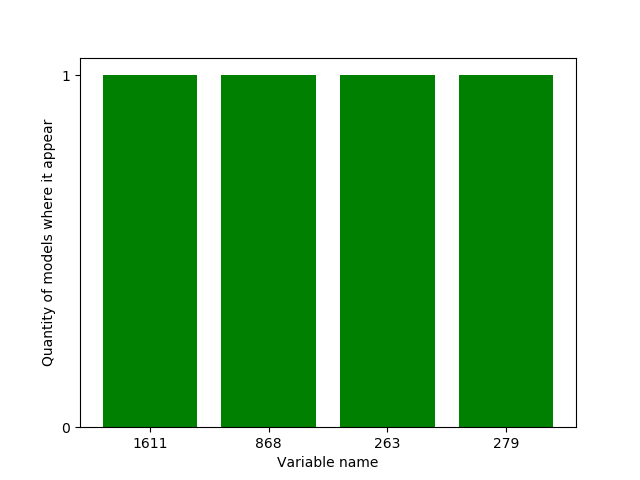

In [43]:
#plot histogram before cut

dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_models_vars)




#indication of the number of models and variables
qty_models = len(list_models_vars)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)


#### Choosing a frequency threshold
Filtering features by frequency will result in a reduction of both the number of features and the number of models, as models with eliminated variables are also eliminated. 

The plot below represents the number of models and variables that should remain after the filter is applied in function of the frequency threshold. It helps you to decide on which threshold to use for the filter.

(Note that the frequency of a feature is calculated as the number of <b>different models</b> where it appears irrespective of the number of rules containing it.)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


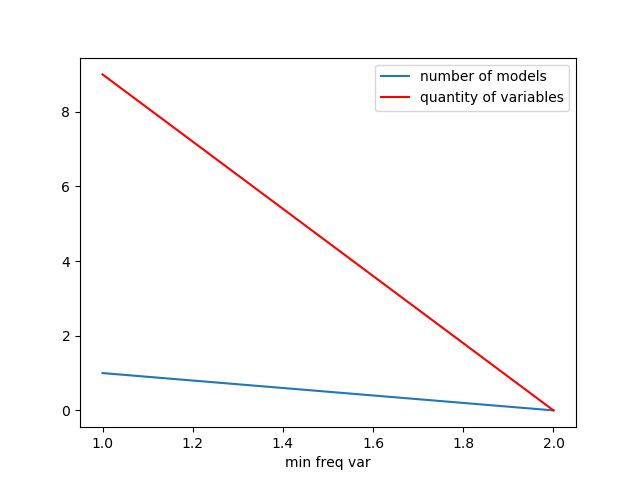

In [68]:
%load_ext autoreload
%autoreload
#Perform the counting
list_models_vars = libraries.interpretability_methods.transformModelsToModelVarObj(list_models_path_complete)
dict_values = libraries.interpretability_methods.countVarFreq(list_models_vars)


#TEST zone
matrix_results = libraries.interpretability_methods.createPlotQtyVarPerModelByMinimumFreq(dict_values,list_models_vars)
#display(matrix_results)
#End test zone



ax = plt.figure().gca()

matrix_results.plot(kind='line',x='min freq var',y='number of models',ax=ax)
matrix_results.plot(kind='line',x='min freq var',y='quantity of variables', color='red', ax=ax)

plt.show()

#libraries.interpretability_plots.plotFreqVarPerFreqMinimum(matrix_results)

based on the plot above, select the minimum frequency (threshold) for the variables on your models.

<b style="background-color:red;color:white">Question 13</b>: Explain your choice of the threshold. (Save both plots into your report)

You need to indicate the name of the file where you want to save the models

In [81]:
#valide the frequence value

#Create a copy of the list that contains the model_var objects
list_models_vars_cpopy = list_models_vars.copy()
#select the minimum frequenty
#-------------------
nb_min_var = 1
#--------------------

#Perform the frequence
list_model_var_resultant = libraries.interpretability_methods.reduceQtyVars(nb_min_var, dict_values,list_models_vars_cpopy)
dict_values_resultant = libraries.interpretability_methods.countVarFreq(list_model_var_resultant)




#indication of the number of models and variables
qty_models = len(list_model_var_resultant)
qty_variables = len(dict_values_resultant)
print("You have {0} models and {1} variables".format(qty_models, qty_variables))

#Plot the new histogram
libraries.interpretability_plots.plotHistogramFreqVar(dict_values_resultant)
#Show the frequency table
dict_Values_ordered = libraries.interpretability_methods.sort_reverse_dictionary_by_values(dict_values_resultant)
datafram_var_freq = pd.DataFrame(list(dict_Values_ordered.items()),columns=['Variable name','Frequence'])
display(datafram_var_freq)


#Perform the list of the models
#--------------------
file_name = 'models_selected.csv'
#--------------------
list_models_names=[model_var.model_path for model_var in list_model_var_resultant]
dataframe_names_files = pd.DataFrame(list_models_names)
dataframe_names_files.to_csv(file_name, sep=',', encoding='utf-8')

You have 1 models and 9 variables


<IPython.core.display.Javascript object>

Variable name  Frequence
0           944          1
1            33          1
2           907          1
3           840          1
4           914          1
5           145          1
6           561          1
7           453          1
8           480          1

Carlos: Don't forget to save the plot resultant of your choice...
<br>
<b>The objective of the lab is to arrived at the end with 5-10 models

# 3. Analysis of the selected models

Now that you have selected the best models, they are saved on the file "models_selected.CSV" (Or other file if you change the name...)
You may then load these models and use them to compute their predictions for the observations in the test set.

In [82]:
%reload_ext autoreload
%autoreload

# Import from file
#--------------------
fis = TrefleFIS.from_tff_file("experiences/all_models/exps_lab_lfa_number_of_rules_var_tuning_weigh_actual_1.0_conf_A_CV_3_rule_3_var_per_rule_4.ftt")
#--------------------
# In the future, it could possible to call clf.predict_classes() directly
# see issue #1
y_pred_test = fis.predict(X_test)

results_list_predictions = np.squeeze(np.asarray(y_pred_test))


#libraries.results_plot.plotCMByTreflePredictions(y_test, results_list_predictions)
#Convert your results into binary values
results = []
for element in y_pred_test:
    print(element)
    if element != 0.5:
        results.append(1)
    else:
        results.append(0)
print(results)
from libraries.ConfusionMatrix import ConfusionMatrix
cm = confusion_matrix(y_test, results)

n_classes = 2
print(cm)
ConfusionMatrix.plot(cm, classes=range(n_classes), title="Confusion Matrix")


[0.5]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.5]
[0.]
[0.]
[0.]
[0.]
[0.5]
[0.5]
[0.5]
[0.5]
[0.5]
[0.]
[0.]
[0.5]
[0.5]
[0.5]
[0.24137931]
[0.5]
[0.]
[0.5]
[0.5]
[0.]
[0.]
[0.]
[0.5]
[0.5]
[0.]
[0.]
[0.5]
[0.]
[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1]
[[11 12]
 [ 5  7]]


The code above is only an example of how to load models and test their performance in the test set. (Remember that the test set is the one who has not been used during the previous training/selectionn steps.)

<b><span style="background-color:red;color:white">Question 14</span></b>: Among the final models, select three of them as follows: the smallest one (in terms of rules and variables), the best one (in terms of performance), and one in the "middle" that you consider as being a good trade-off between size and performance. With them:
<ul>
    <li>Apply them to the test set and analyze the results you obtained</li>
    <li>Analyze them in terms of size, rules, vars per rules and other characteristics that you think are relevant</li>
    <li>As far as possible, analyze their rules and try to "explain" their predictions.
</ul>
<br>
Tips: You can use plots to described your results...